In [1]:
import os
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from matplotlib.ticker import MultipleLocator
import nibabel as nib
import pickle
from importlib import reload

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

print(sys.path)
%pwd

['/home/rfpred/notebooks', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode']


'/home/rfpred'

In [2]:
from funcs.imgproc import get_imgs_designmx, rms_all, feature_df, show_stim, get_rms_contrast, get_rms_contrast_lab, get_contrast_df, get_img_prf, get_visfeature_dict
from funcs.rf_tools import get_mask, css_gaussian_cut, make_circle_mask, make_visrois_dict, write_prf_dict
from funcs.utility import print_dict_structure, print_large, get_zscore, mean_center, hypotheses_plot, multiple_regression
from funcs.analyses import multivariate_regression, regression_dict_multivariate, plot_roi_beta_distribution, get_hrf_dict, plot_beta_to_icept, reg_plots, univariate_regression, multivariate_regression
from funcs.utility import numpy2coords, coords2numpy, filter_array_by_size, find_common_rows
# from funcs.viscontrasts import lgn_statistics
from notebooks.alien_nbs.lgnpy.lgnpy.CEandSC import lgn_statistics

Run this to reload the functions without having to restart the entire kernel.

In [3]:
import importlib
import funcs.imgproc
import funcs.rf_tools
import funcs.utility
import funcs.analyses
import notebooks.alien_nbs.lgnpy.lgnpy.CEandSC

# Reload the modules
importlib.reload(funcs.imgproc)
importlib.reload(funcs.rf_tools)
importlib.reload(funcs.utility)
importlib.reload(funcs.analyses)
importlib.reload(notebooks.alien_nbs.lgnpy.lgnpy.CEandSC)

# Re-import the functions
from funcs.imgproc import get_imgs_designmx, rms_all, feature_df, show_stim, get_rms_contrast, get_rms_contrast_lab, get_contrast_df, get_img_prf, get_visfeature_dict
from funcs.rf_tools import get_mask, css_gaussian_cut, make_circle_mask, make_visrois_dict, write_prf_dict
from funcs.utility import print_dict_structure, print_large, get_zscore, mean_center, hypotheses_plot, multiple_regression
from funcs.analyses import multivariate_regression, regression_dict_multivariate, plot_roi_beta_distribution, get_hrf_dict, plot_beta_to_icept, reg_plots, univariate_regression, multivariate_regression
from funcs.utility import numpy2coords, coords2numpy, filter_array_by_size, find_common_rows
from notebooks.alien_nbs.lgnpy.lgnpy.CEandSC import lgn_statistics

In [4]:
n_subjects = len(os.listdir('/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata'))
vismask_dict = make_visrois_dict(vox_count = 'y', bin_check = 'n', n_subjects=n_subjects)
prf_dict = write_prf_dict(binary_masks = vismask_dict)

Subject 1
V1_mask
Non-zero voxels in V1_mask: 7887
V2_mask
Non-zero voxels in V2_mask: 8296
V3_mask
Non-zero voxels in V3_mask: 7022
V4_mask
Non-zero voxels in V4_mask: 3976
Subject 2
V1_mask
Non-zero voxels in V1_mask: 6476
V2_mask
Non-zero voxels in V2_mask: 6376
V3_mask
Non-zero voxels in V3_mask: 6236
V4_mask
Non-zero voxels in V4_mask: 2887
Subject 3
V1_mask
Non-zero voxels in V1_mask: 7358
V2_mask
Non-zero voxels in V2_mask: 6721
V3_mask
Non-zero voxels in V3_mask: 5316
V4_mask
Non-zero voxels in V4_mask: 2486
Subject 4
V1_mask
Non-zero voxels in V1_mask: 5119
V2_mask
Non-zero voxels in V2_mask: 5088
V3_mask
Non-zero voxels in V3_mask: 4669
V4_mask
Non-zero voxels in V4_mask: 2790
Subject 5
V1_mask
Non-zero voxels in V1_mask: 6502
V2_mask
Non-zero voxels in V2_mask: 6309
V3_mask
Non-zero voxels in V3_mask: 5383
V4_mask
Non-zero voxels in V4_mask: 3184
Subject 6
V1_mask
Non-zero voxels in V1_mask: 6479
V2_mask
Non-zero voxels in V2_mask: 6905
V3_mask
Non-zero voxels in V3_mask: 71

Load in the visual contrast features (currently only rms)

In [5]:
# Load in the original RMS dict (where RMS is calculated before cropping)
with open('./data/custom_files/all_visfeats_rms.pkl', 'rb') as fp:
   visfeats_rms = pickle.load(fp)
   
# Load in the new RMS dict (where RMS is calculated after cropping, thus cropping prior to RMS)
with open('./data/custom_files/all_visfeats_rms_crop_prior.pkl', 'rb') as fp:
   visfeats_rms_crop_prior = pickle.load(fp)

Load in the pRF based voxel selection masks. Important to notice is that these masks are different form the voxmasks created using the get_hrf_dict function, as those filter out even more voxels based on newly included restrictions. Thus, the prf_masks are more liberal than the voxmasks. The reason for this is because it allows us to do some precise voxel selection of an intitial relatively rough selection, without having to retrieve a completely new mask. 

In [6]:

# Load in the saved masks for selected voxels that have their prf inside the inner patch.
with open('./data/custom_files/subj01/prf_mask_center_strict.pkl', 'rb') as fp:
    prf_mask_center_strict = pickle.load(fp)
    
    
with open('./data/custom_files/subj01/prf_mask_central_loose.pkl', 'rb') as fp:
    prf_mask_central_loose = pickle.load(fp) 
    

# Load in the saved file
with open('./data/custom_files/subj01/prf_mask_periphery_strict.pkl', 'rb') as fp:
   prf_mask_periphery_strict = pickle.load(fp)


# Load in the saved file
with open('./data/custom_files/subj01/prf_mask_central_strict_l.pkl', 'rb') as fp:
   prf_mask_center_strict_l = pickle.load(fp)

Load in the HRF signal dictionaries for different voxel selections

beta_dict0_2.pkl
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Processed images: 2250
beta_dict3_5.pkl
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Processed images: 4500
beta_dict6_10.pkl
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Processed images: 8250
beta_dict11_15.pkl
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Processed images: 12000
beta_dict16_20.pkl
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Processed images: 15750
beta_dict21_27.pkl
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Processed images: 21000
beta_dict28_35.pkl
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Processed images: 27000
beta_dict36_39.pkl
	Amount of voxels: 150
	Amount of vox

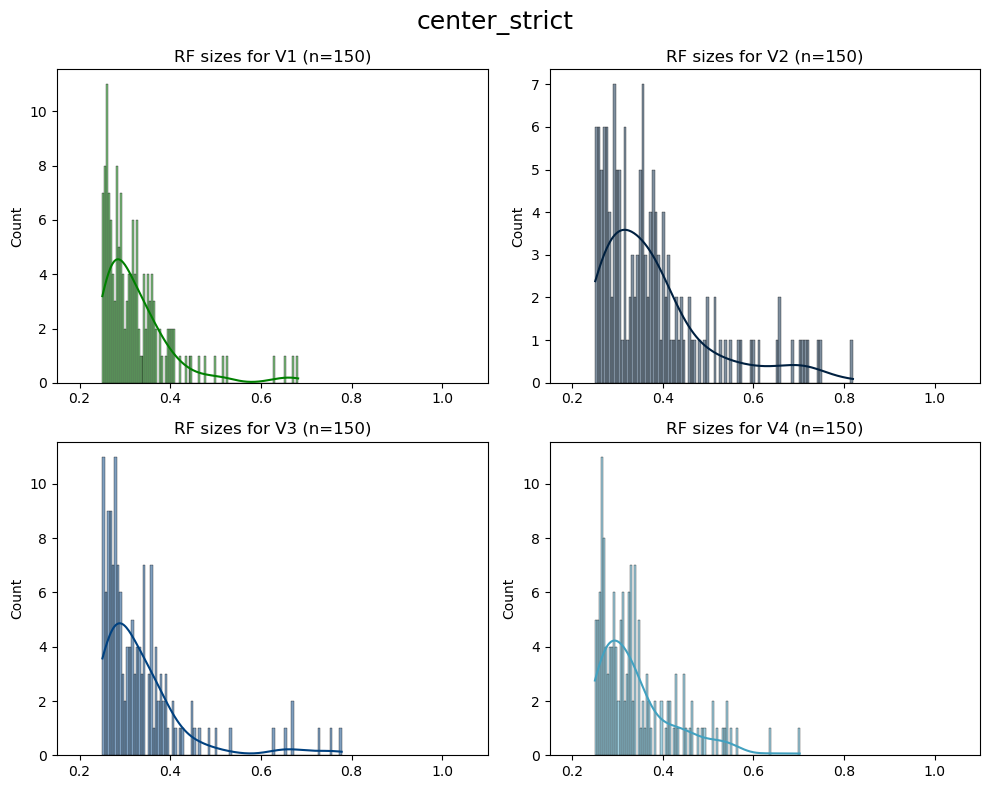

In [27]:
# 1 min
# hrf_dict = get_hrf_dict('subj01', voxels = prf_selection_mask)
hrf_dict_tight, voxmask_tight, joint_voxs, sizes  = get_hrf_dict('subj01', voxels = prf_mask_center_strict, prf_region = 'center_strict', 
                                             min_size = .25, max_size = 1, prf_proc_dict = prf_dict, vox_n_cutoff = 150,plot_sizes = 'y')



beta_dict0_5_center_loose.pkl
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Processed images: 4500
beta_dict6_15_center_loose.pkl
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Processed images: 12000
beta_dict16_25_center_loose.pkl
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Processed images: 19500
beta_dict26_35_center_loose.pkl
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Processed images: 27000
beta_dict36_39_center_loose.pkl
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Processed images: 30000


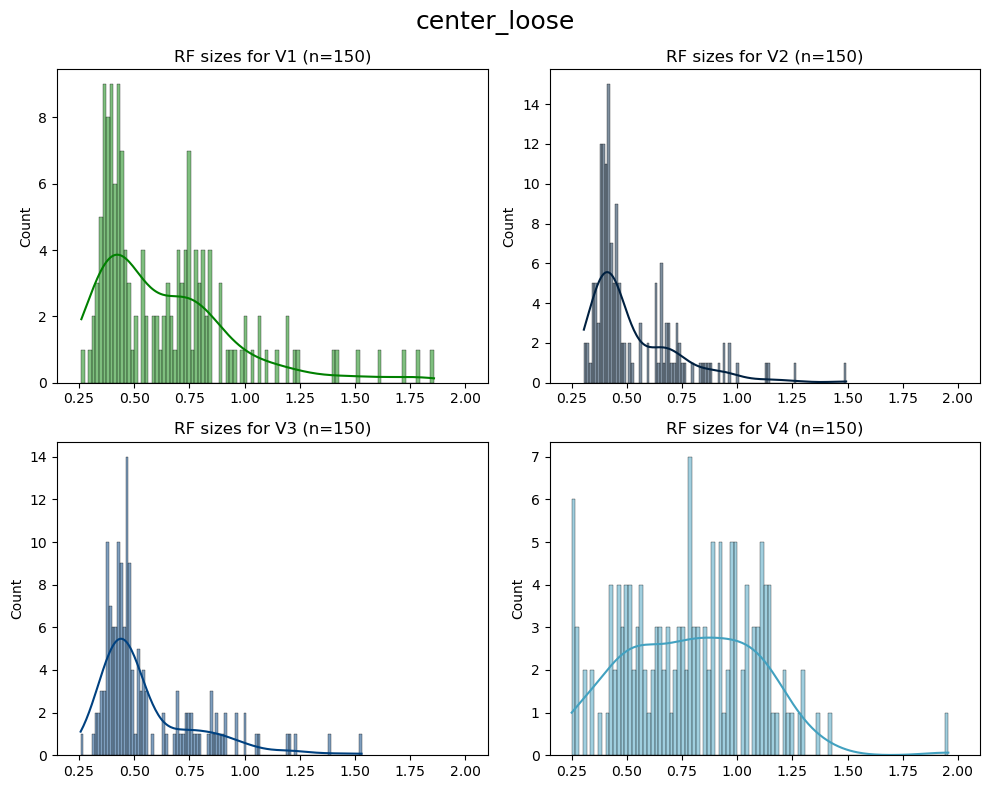

In [8]:
# Create the hrf_dict for the periphery with sizes .2 to 1

hrf_dict_central_loose, voxmask_central_loose, joint_voxs, sizes = get_hrf_dict('subj01', prf_mask_central_loose, prf_region = 'center_loose', 
                                                                    min_size = .25, max_size = 2, prf_proc_dict = prf_dict, 
                                                                    vox_n_cutoff = 150, plot_sizes = 'y')

beta_dict0_5_periphery.pkl
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Processed images: 4500
beta_dict6_15_periphery.pkl
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Processed images: 12000
beta_dict16_25_periphery.pkl
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Processed images: 19500
beta_dict26_35_periphery.pkl
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Processed images: 27000
beta_dict36_39_periphery.pkl
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Processed images: 30000


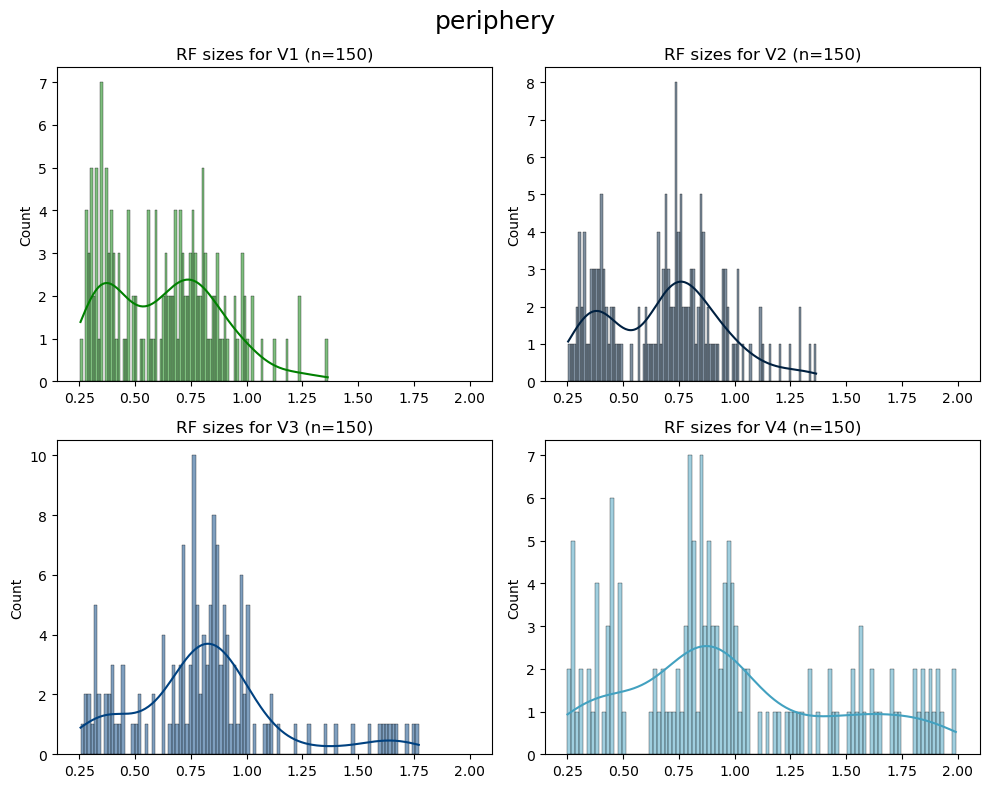

In [9]:
# Create the hrf_dict for the periphery with sizes .2 to 1
# The plot shows the ROI-specific distribution of RF sizes
hrf_dict_peri, voxmask_tight_peri, joint_voxs, sizes = get_hrf_dict('subj01', prf_mask_periphery_strict, prf_region = 'periphery', 
                                                                    min_size = .25, max_size = 2, prf_proc_dict = prf_dict, 
                                                                    vox_n_cutoff = 150, plot_sizes = 'y')


beta_dict0_9_center_strict_l.pkl


	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Processed images: 7500
beta_dict10_20_center_strict_l.pkl
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Processed images: 15750
beta_dict21_39_center_strict_l.pkl
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Amount of voxels: 150
	Processed images: 30000


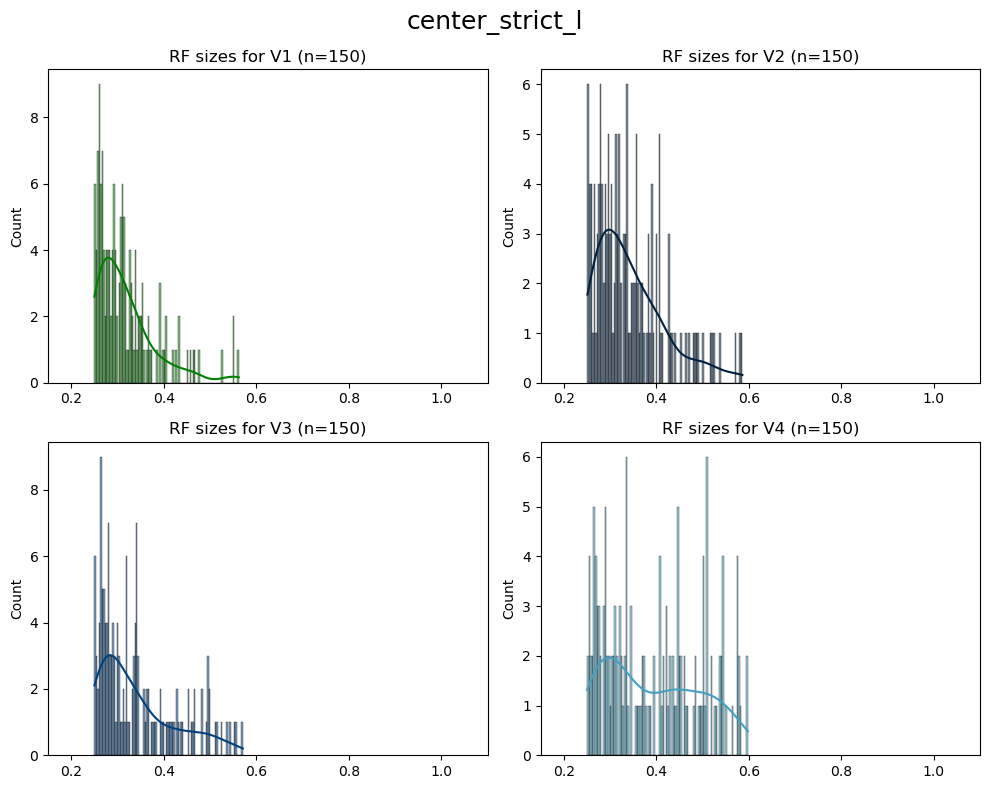

In [10]:
# 1 min
# hrf_dict = get_hrf_dict('subj01', voxels = prf_selection_mask)
hrf_dict_tight_l, voxmask_tight_l, joint_voxs, sizes  = get_hrf_dict('subj01', voxels = prf_mask_center_strict_l, prf_region = 'center_strict_l', 
                                             min_size = .25, max_size = 1, prf_proc_dict = prf_dict, vox_n_cutoff = 150, plot_sizes = 'y')



In [11]:
# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_rmsrel_mcmc, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_mc',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False, meancentery = True,)

regdict_prfc_tight_rmsirrel_mcmc, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_mc', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False, meancentery=True)

# Regression for the relevant and irrelevant RMS values for the central loose RFs

regdict_prfc_loose_rmsrel_mcmc, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_mc',voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False, meancentery=True)

regdict_prfc_loose_rmsirrel_mcmc, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_mc', voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False, meancentery=True)

# Regression for the relevant and irrelevant RMS values for the strict peripheral RFs

regdict_prfp_tight_rmsrel_mcmc, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_mc',voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False, meancentery=True)


# Does this make sense? no not really. These is a comparison between peripheral RF HRF signal and the irrelevant RMS values (which a proportion of the
# RFs actually overlap with). I could check out whether peripheral RFs are location specific in their responses, but that is like a sanity check
# of a sanity check of a sanity check, not really crucial.
regdict_prfp_tight_rmsirrel_mcmc, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_mc', voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False, meancentery=True)



In [12]:
regstash_mcmc = {}

regstash_mcmc['centralprfs'] = {
    'tight': {
        'rel': regdict_prfc_tight_rmsrel_mcmc,
        'irrel': regdict_prfc_tight_rmsirrel_mcmc
    },
    'loose': {
        'rel': regdict_prfc_loose_rmsrel_mcmc,
        'irrel': regdict_prfc_loose_rmsirrel_mcmc
    }

}

regstash_mcmc['peripheralprfs'] = {
    'tight': {
        'rel': regdict_prfp_tight_rmsrel_mcmc,
        'irrel': regdict_prfp_tight_rmsirrel_mcmc
    }
}

In [13]:
# The old z-score (over total)
# regdict_prfc_tight_rmsrel_z['V1_mask']['y_matrix']

# array([[-0.43006, -0.29205, -0.08803, ..., -0.48806, -0.8481 , -1.86018],
#        [-1.00411, -0.72609, -0.24604, ..., -0.21204, -0.27405, -1.19013],
#        [-1.15012, -0.31005, -0.23404, ..., -0.10803, -2.73426,  0.69804],
#        ...,
#        [-0.9241 ,  0.286  ,  0.15999, ...,  0.212  , -3.1403 ,  1.4061 ],
#        [-0.02802,  0.13399,  0.51402, ...,  0.238  , -3.50033,  0.80805],
#        [-0.73609,  0.14799,  0.06198, ..., -0.17804, -5.4525 ,  1.61012]])


In [14]:
# The new z-score (per session)
# regdict_prfc_tight_rmsrel_z['V1_mask']['y_matrix']

# array([[-0.65082, -0.50525, -0.29005, ..., -0.71201, -1.09177, -2.15934],
#        [-1.25634, -0.96308, -0.45672, ..., -0.42085, -0.48626, -1.45255],
#        [-1.41036, -0.52424, -0.44406, ..., -0.31114, -3.08133,  0.53911],
#        ...,
#        [-0.9747 ,  0.42263,  0.27712, ...,  0.33717, -3.53376,  1.71602],
#        [ 0.06002,  0.2471 ,  0.68592, ...,  0.3672 , -3.94949,  1.02544],
#        [-0.75759,  0.26326,  0.16395, ..., -0.11321, -6.20368,  1.9516 ]])


### GOEDEMORGEN, HIER AAN DE SLAG!!!!!!!! KOPIEER EN VERVANG VISFEATS_RMS VOOR VISFEATS_RMS_CROP_PRIOR


In [15]:
# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_rmsrel_mc, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False, meancentery = True,)

regdict_prfc_tight_rmsirrel_mc, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False, meancentery=True)

# Regression for the relevant and irrelevant RMS values for the central loose RFs

regdict_prfc_loose_rmsrel_mc, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False, meancentery=True)

regdict_prfc_loose_rmsirrel_mc, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False, meancentery=True)

# Regression for the relevant and irrelevant RMS values for the strict peripheral RFs

regdict_prfp_tight_rmsrel_mc, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False, meancentery=True)


# Does this make sense? no not really. These is a comparison between peripheral RF HRF signal and the irrelevant RMS values (which a proportion of the
# RFs actually overlap with). I could check out whether peripheral RFs are location specific in their responses, but that is like a sanity check
# of a sanity check of a sanity check, not really crucial.

regdict_prfp_tight_rmsirrel_mc, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False, meancentery=True)



In [16]:
regstash_mc = {}

regstash_mc['centralprfs'] = {
    'tight': {
        'rel': regdict_prfc_tight_rmsrel_mc,
        'irrel': regdict_prfc_tight_rmsirrel_mc
    },
    'loose': {
        'rel': regdict_prfc_loose_rmsrel_mc,
        'irrel': regdict_prfc_loose_rmsirrel_mc
    }

}

regstash_mc['peripheralprfs'] = {
    'tight': {
        'rel': regdict_prfp_tight_rmsrel_mc,
        'irrel': regdict_prfp_tight_rmsirrel_mc
    }
}

In [17]:
# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_rmsrel_z, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = True)

regdict_prfc_tight_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = True)


# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_l_rmsrel_z, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight_l, hrf_dict_tight_l, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = True)

regdict_prfc_tight_l_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight_l, hrf_dict_tight_l, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = True)


# Regression for the relevant and irrelevant RMS values for the central loose RFs

regdict_prfc_loose_rmsrel_z, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = True)

regdict_prfc_loose_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = True)

# Regression for the relevant and irrelevant RMS values for the strict peripheral RFs

regdict_prfp_tight_rmsrel_z, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = True)


# Does this make sense? no not really. These is a comparison between peripheral RF HRF signal and the irrelevant RMS values (which a proportion of the
# RFs actually overlap with). I could check out whether peripheral RFs are location specific in their responses, but that is like a sanity check
# of a sanity check of a sanity check, not really crucial.
regdict_prfp_tight_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = True)



In [18]:
regstash_z = {}

regstash_z['centralprfs'] = {
    'tight': {
        'rel': regdict_prfc_tight_rmsrel_z,
        'irrel': regdict_prfc_tight_rmsirrel_z
    },
    'tight_l': {
        'rel': regdict_prfc_tight_l_rmsrel_z,
        'irrel': regdict_prfc_tight_l_rmsirrel_z
    },
    'loose': {
        'rel': regdict_prfc_loose_rmsrel_z,
        'irrel': regdict_prfc_loose_rmsirrel_z
    }
}

regstash_z['peripheralprfs'] = {
    'tight': {
        'rel': regdict_prfp_tight_rmsrel_z,
        'irrel': regdict_prfp_tight_rmsirrel_z
    }
}

#### Here I create yet another dictionary to check whether it matters if images are cropped prior or post calculating RMS. This is for cropping it prior to calculating, the original crops post calculating RMS (potentially impacting results).

In [19]:
# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_rmsrel_z, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms_crop_prior['subj01']['rms'], n_imgs=30000, z_scorey = True)

regdict_prfc_tight_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms_crop_prior['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = True)


# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_l_rmsrel_z, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight_l, hrf_dict_tight_l, 
                                                                                            visfeats_rms_crop_prior['subj01']['rms'], n_imgs=30000, z_scorey = True)

regdict_prfc_tight_l_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight_l, hrf_dict_tight_l, 
                                                                                            visfeats_rms_crop_prior['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = True)


# Regression for the relevant and irrelevant RMS values for the central loose RFs

regdict_prfc_loose_rmsrel_z, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms_crop_prior['subj01']['rms'], n_imgs=30000, z_scorey = True)

regdict_prfc_loose_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms_crop_prior['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = True)

# Regression for the relevant and irrelevant RMS values for the strict peripheral RFs

regdict_prfp_tight_rmsrel_z, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms_crop_prior['subj01']['rms'], n_imgs=30000, z_scorey = True)


# Does this make sense? no not really. These is a comparison between peripheral RF HRF signal and the irrelevant RMS values (which a proportion of the
# RFs actually overlap with). I could check out whether peripheral RFs are location specific in their responses, but that is like a sanity check
# of a sanity check of a sanity check, not really crucial.
regdict_prfp_tight_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms_crop_prior['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = True)

regstash_z_crop_prior = {}

regstash_z_crop_prior['centralprfs'] = {
    'tight': {
        'rel': regdict_prfc_tight_rmsrel_z,
        'irrel': regdict_prfc_tight_rmsirrel_z
    },
    'tight_l': {
        'rel': regdict_prfc_tight_l_rmsrel_z,
        'irrel': regdict_prfc_tight_l_rmsirrel_z
    },
    'loose': {
        'rel': regdict_prfc_loose_rmsrel_z,
        'irrel': regdict_prfc_loose_rmsirrel_z
    }
}

regstash_z_crop_prior['peripheralprfs'] = {
    'tight': {
        'rel': regdict_prfp_tight_rmsrel_z,
        'irrel': regdict_prfp_tight_rmsirrel_z
    }
}

In [20]:
X_check = (regdict_prfc_tight_rmsrel_z['V1_mask']['X_matrix'])
y_check = (regdict_prfc_tight_rmsrel_z['V1_mask']['y_matrix'])

print(X_check.shape)
print(y_check.shape)

print(f'mean of X: {np.mean(X_check)}')
print(f'mean of y: {np.mean(y_check)}')

print(f'std of X: {np.std(X_check)}')
print(f'std of y: {np.std(y_check)}')

ub, ui, ur, um, uX, uy = univariate_regression(X_check, y_check, z_scorey = True, meancentery = False)
print(ui)


(30000, 1)
(30000, 150)
mean of X: 4.784321087451341e-16
mean of y: -4.9011658928874465e-18
std of X: 1.0
std of y: 1.0
[-0.52121 -0.43727 -0.48506 -0.39494 -0.43195 -0.49513 -0.32251 -0.33038
 -0.3884  -0.30053 -0.45129 -0.4741  -0.24485 -0.55534 -0.37129 -0.37658
 -0.31937  0.52829 -0.56098  0.53028 -0.18482 -0.08159 -0.07913  0.07135
 -0.18247 -0.23861 -0.22533  0.2121   0.01038 -0.07369 -0.21836 -0.32779
 -0.42808 -0.44179  0.29242  0.10341 -0.1756  -0.54666 -0.17763 -0.44596
 -0.46441  0.17853  0.11983 -0.07272  0.81303  0.70549 -0.16458 -0.3484
 -0.40818  0.62465  0.80114  0.80852  0.50132  0.02608 -0.15982 -0.22414
 -0.30869 -0.37924  0.5067   0.52652  0.47938  0.3069   0.11751  0.02616
 -0.04526 -0.19205 -0.22323 -0.20909 -0.26301 -0.34074  1.67934  0.60352
  0.28926  0.15193  0.139    0.12138  0.08087 -0.00364 -0.1545  -0.22871
 -0.20854 -0.23051 -0.30145 -0.37477  1.60131  0.76133  0.21627 -0.019
  0.01473  0.04595 -0.01024 -0.06268 -0.14601 -0.22054 -0.31501 -0.47441
 -3.494

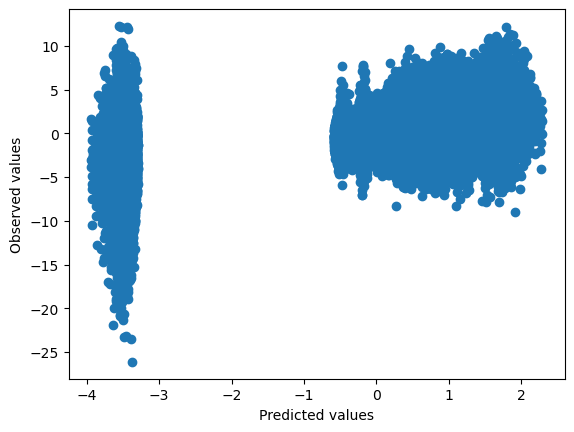

In [21]:
import matplotlib.pyplot as plt

# Predicted values
y_pred = um.predict(uX)

plt.scatter(y_pred, uy)
plt.xlabel('Predicted values')
plt.ylabel('Observed values')
plt.show()

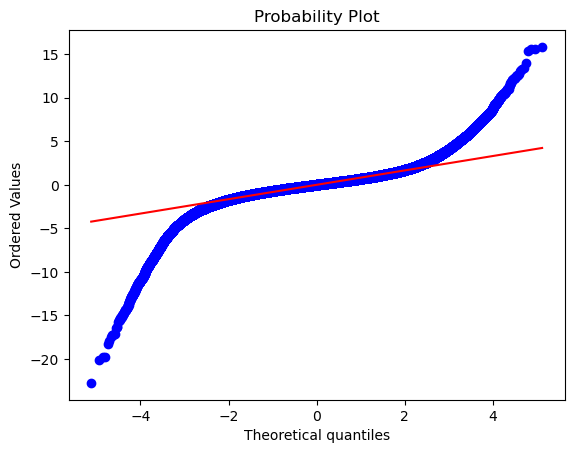

In [22]:
import scipy.stats as stats

residuals = uy - y_pred

stats.probplot(residuals.flatten(), dist="norm", plot=plt)
plt.show()

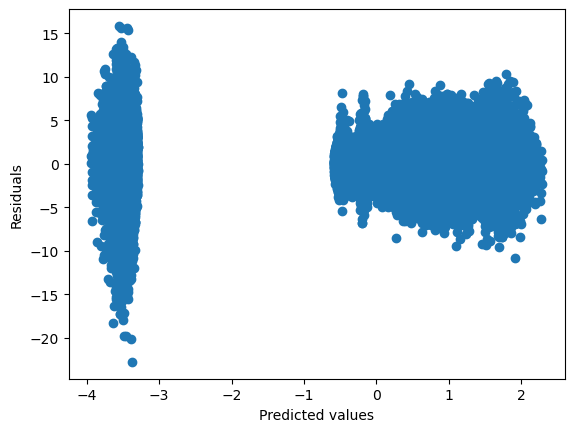

In [23]:
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

In [24]:
# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_rmsrel, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False)

regdict_prfc_tight_rmsirrel, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False)

# Regression for the relevant and irrelevant RMS values for the central loose RFs

regdict_prfc_loose_rmsrel, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False)

regdict_prfc_loose_rmsirrel, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False)

# Regression for the relevant and irrelevant RMS values for the strict peripheral RFs

regdict_prfp_tight_rmsrel, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False)

# Does this make sense? no not really. These is a comparison between peripheral RF HRF signal and the irrelevant RMS values (which a proportion of the
# RFs actually overlap with). I could check out whether peripheral RFs are location specific in their responses, but that is like a sanity check
# of a sanity check of a sanity check, not really crucial.
regdict_prfp_tight_rmsirrel, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False)



Stash the different regression dictionaries in another dictionary to make access more intuitive.

In [25]:
regstash = {}

regstash['centralprfs'] = {
    'tight': {
        'rel': regdict_prfc_tight_rmsrel,
        'irrel': regdict_prfc_tight_rmsirrel
    },
    'loose': {
        'rel': regdict_prfc_loose_rmsrel,
        'irrel': regdict_prfc_loose_rmsirrel
    }

}

regstash['peripheralprfs'] = {
    'tight': {
        'rel': regdict_prfp_tight_rmsrel,
        'irrel': regdict_prfp_tight_rmsirrel
    }
}

### Raw vs. Z-score vs. Mean centering

In [72]:

reg_plots(regstash['centralprfs']['loose']['rel'], dictdescrip1 = 'Loosely central pRFs to patch RMS', comptype = 'Central vs. Peripheral RFs (non-standardized)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS', beta_hist = True, beta_icept = True)

NameError: name 'regstash' is not defined

### NEW CHECK FOR CROP POSTERIOR SHIT, IF IT SEEMS TO MATTER, CHANGE ALL RMS VALUES INTO NEW ONES

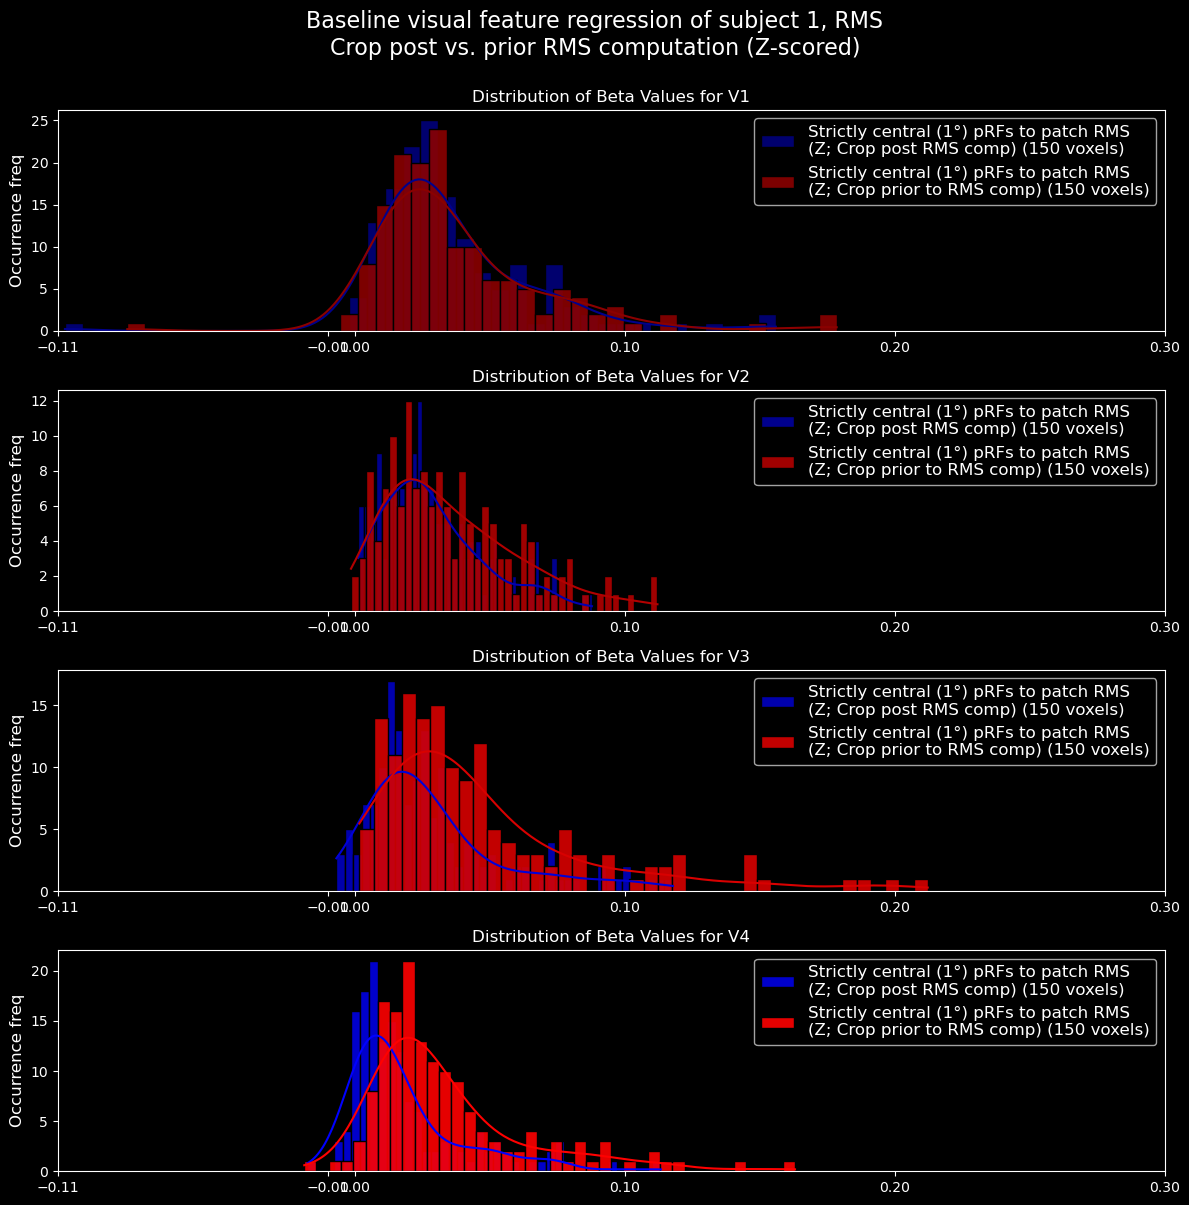

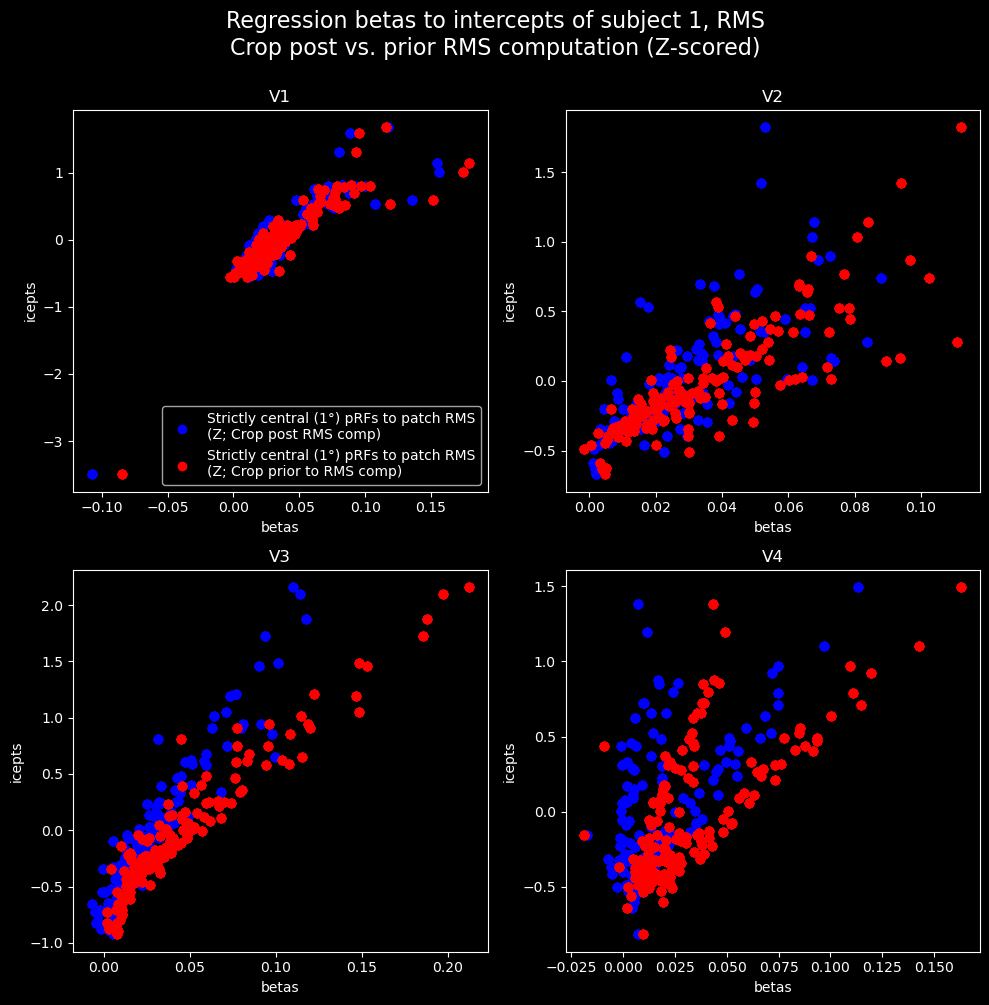

In [153]:

# ORIGINAL SIZE STRICT CENTRAL VS 1.25 RADIUS CENTRAL STRICT
# CHECK WHETHER OG SIZE IS FINE, WHAT IS ADDED VALUE OF EXTRA VOXELS


reg_plots(regstash_z['centralprfs']['tight']['rel'], dictdescrip1 = 'Strictly central (1°) pRFs to patch RMS\n(Z; Crop post RMS comp)', comptype = 'Crop post vs. prior RMS computation (Z-scored)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z_crop_prior['centralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly central (1°) pRFs to patch RMS\n(Z; Crop prior to RMS comp)', beta_hist = True, beta_icept = True)

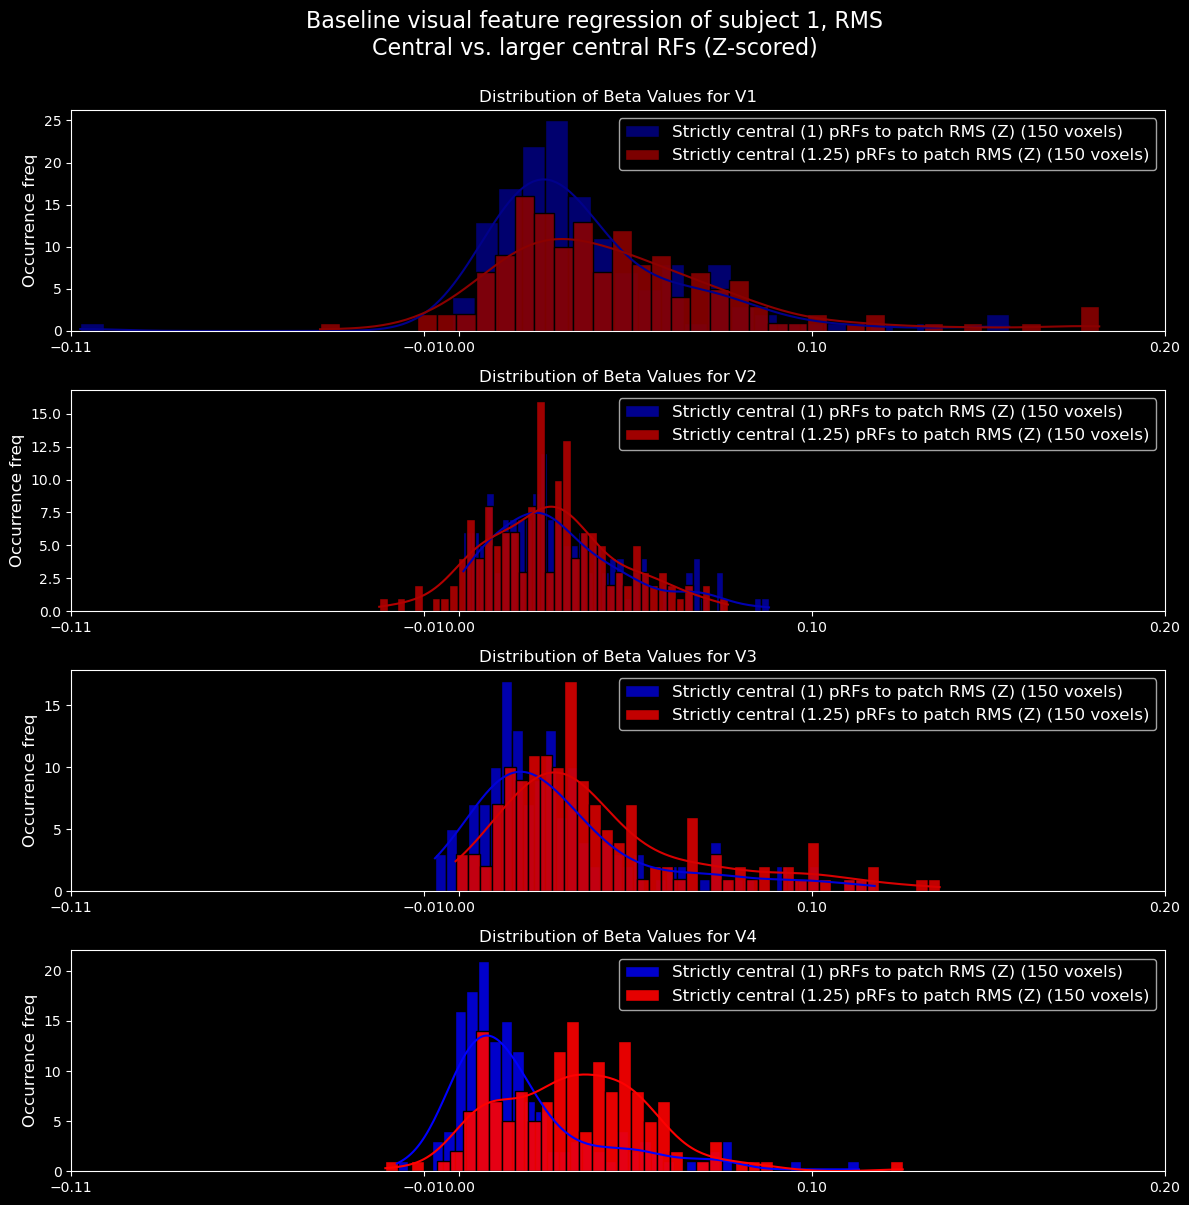

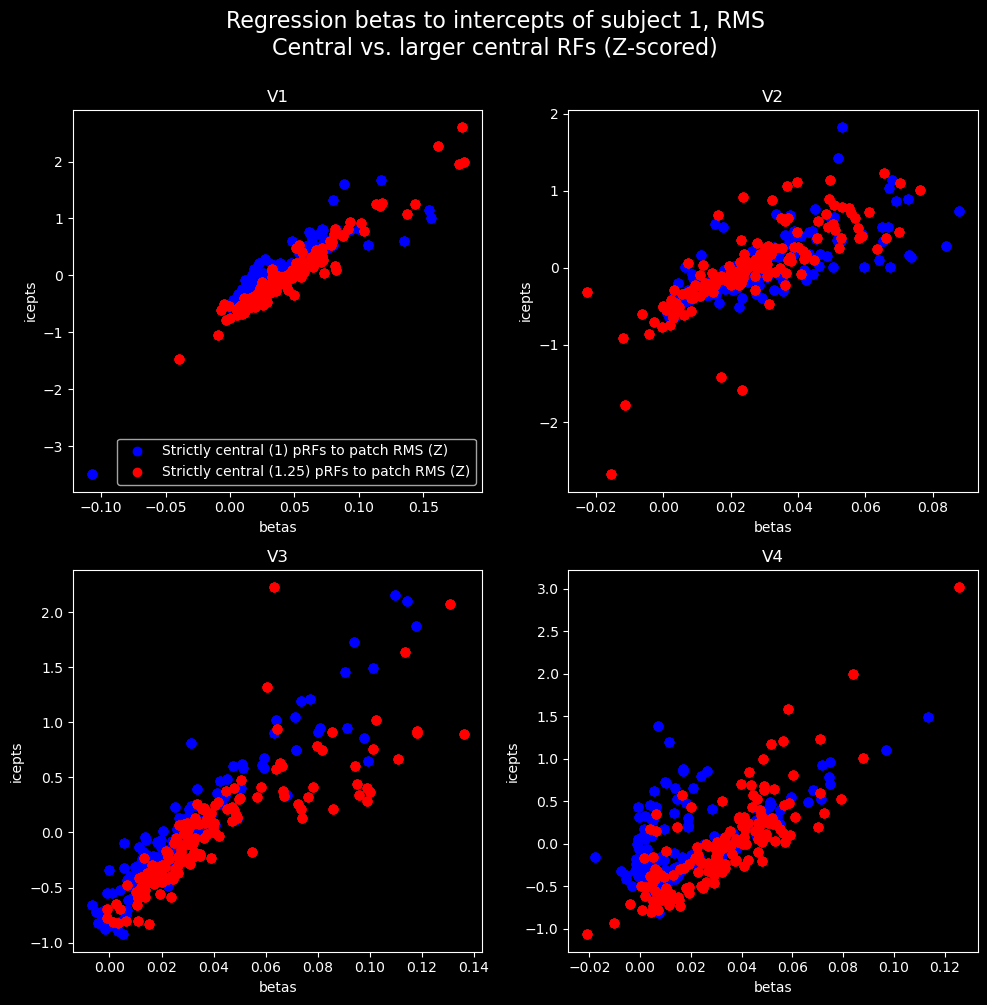

In [108]:
# ORIGINAL SIZE STRICT CENTRAL VS 1.25 RADIUS CENTRAL STRICT
# CHECK WHETHER OG SIZE IS FINE, WHAT IS ADDED VALUE OF EXTRA VOXELS


reg_plots(regstash_z['centralprfs']['tight']['rel'], dictdescrip1 = 'Strictly central (1) pRFs to patch RMS (Z)', comptype = 'Central vs. larger central RFs (Z-scored)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z['centralprfs']['tight_l']['rel'], 
                           dictdescrip2 = 'Strictly central (1.25) pRFs to patch RMS (Z)', beta_hist = True, beta_icept = True)

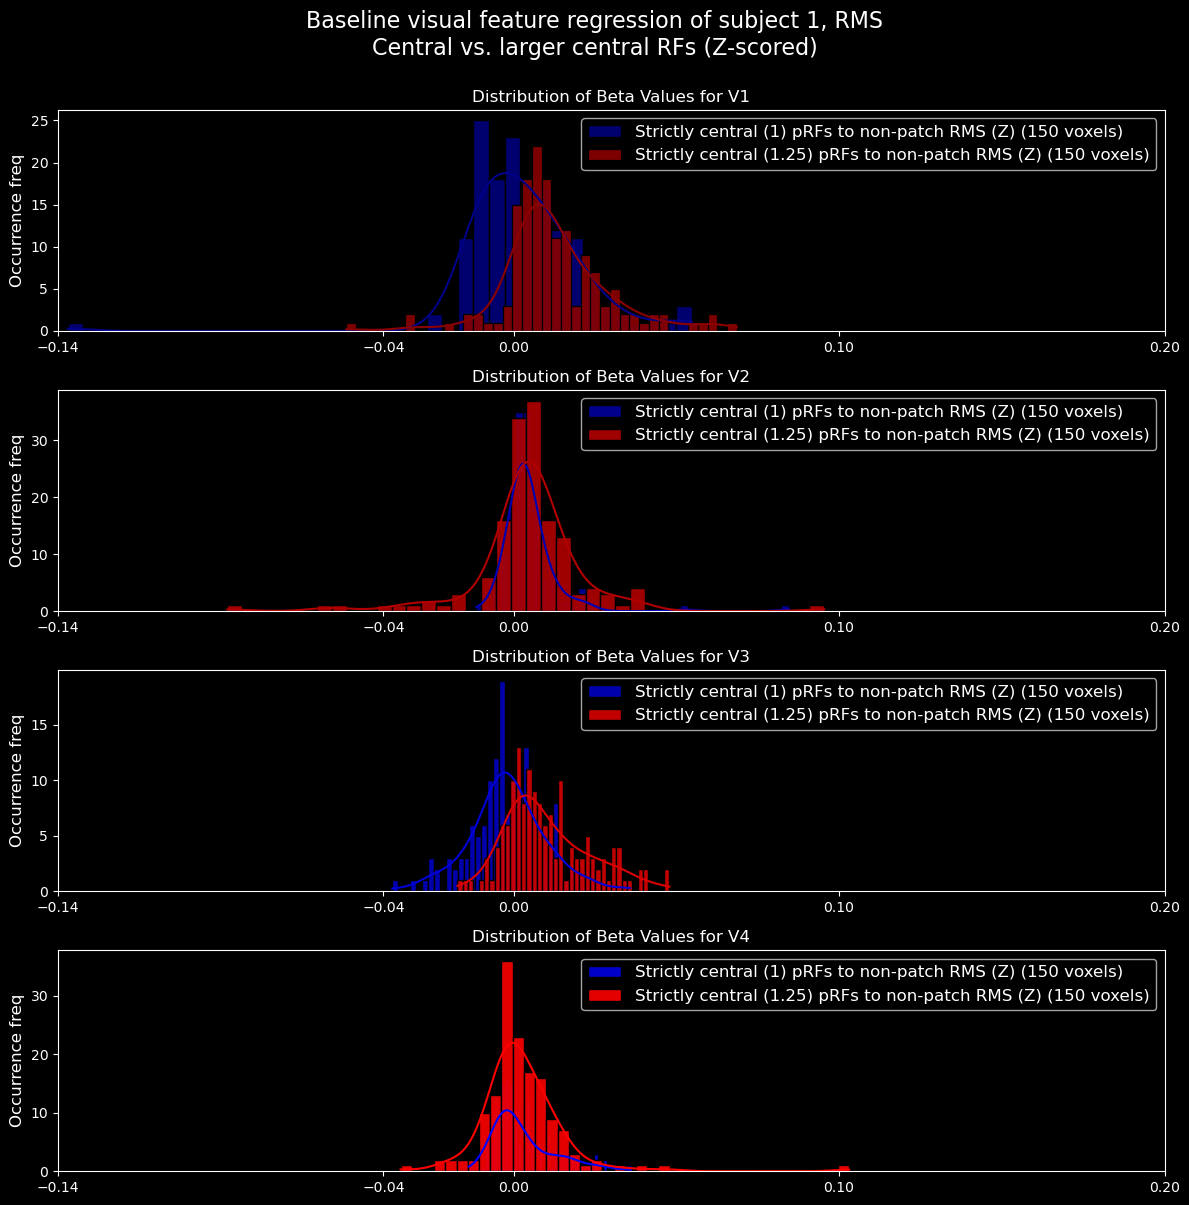

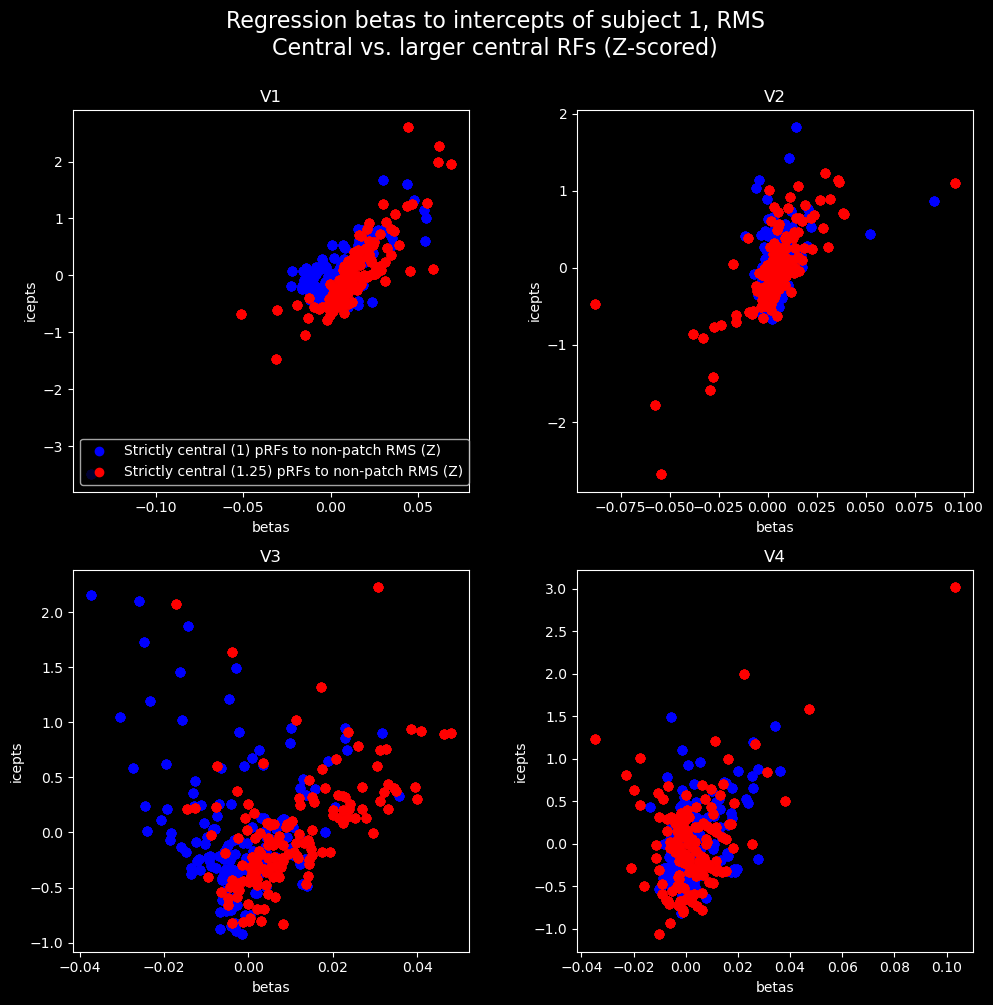

In [109]:
# ORIGINAL SIZE STRICT CENTRAL VS 1.25 RADIUS CENTRAL STRICT
# HERE THE 1 RADIUS SEEMS TO BE BETTER, AS IT IS NON RESPONSIVE TO THE IRRELEVANT RMS VALUES


reg_plots(regstash_z['centralprfs']['tight']['irrel'], dictdescrip1 = 'Strictly central (1) pRFs to non-patch RMS (Z)', comptype = 'Central vs. larger central RFs (Z-scored)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z['centralprfs']['tight_l']['irrel'], 
                           dictdescrip2 = 'Strictly central (1.25) pRFs to non-patch RMS (Z)', beta_hist = True, beta_icept = True)

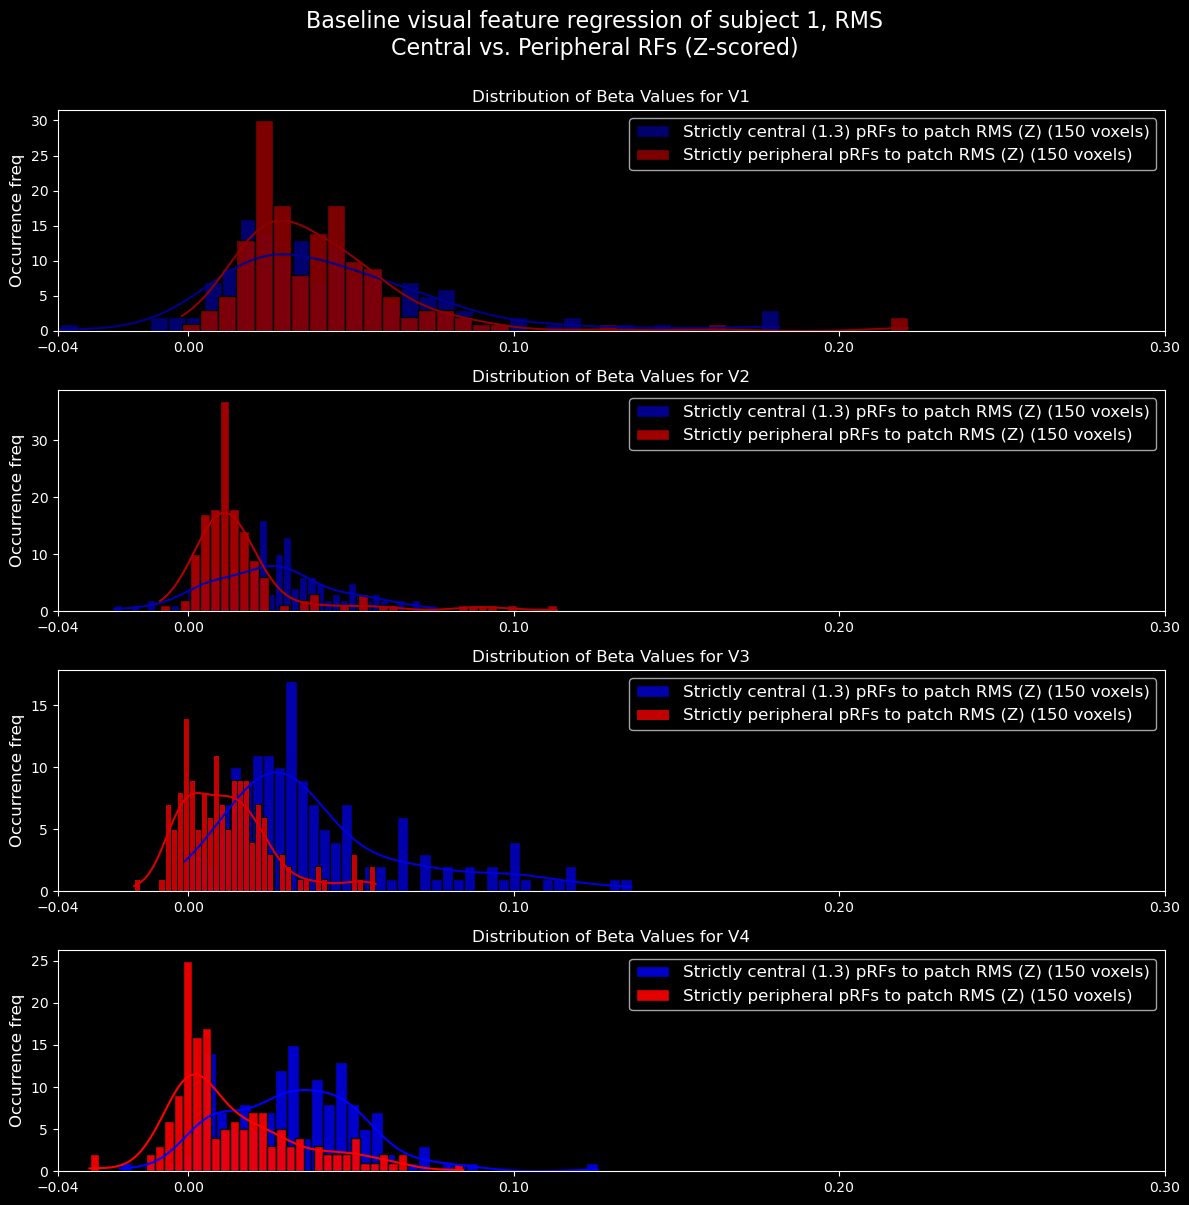

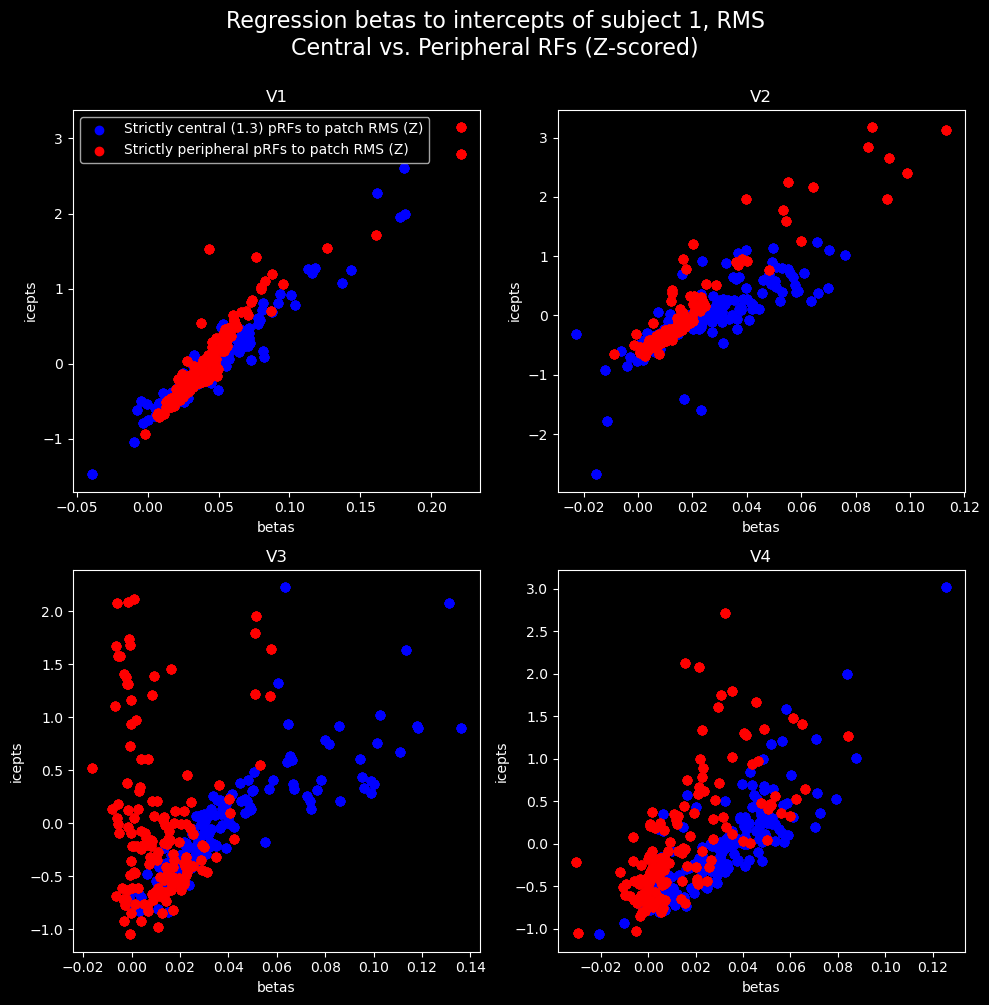

In [112]:
# Comparing the larger central strict RFs to the peripheral strict RFs
reg_plots(regstash_z['centralprfs']['tight_l']['rel'], dictdescrip1 = 'Strictly central (1.3) pRFs to patch RMS (Z)', comptype = 'Central vs. Peripheral RFs (Z-scored)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS (Z)', beta_hist = True, beta_icept = True)

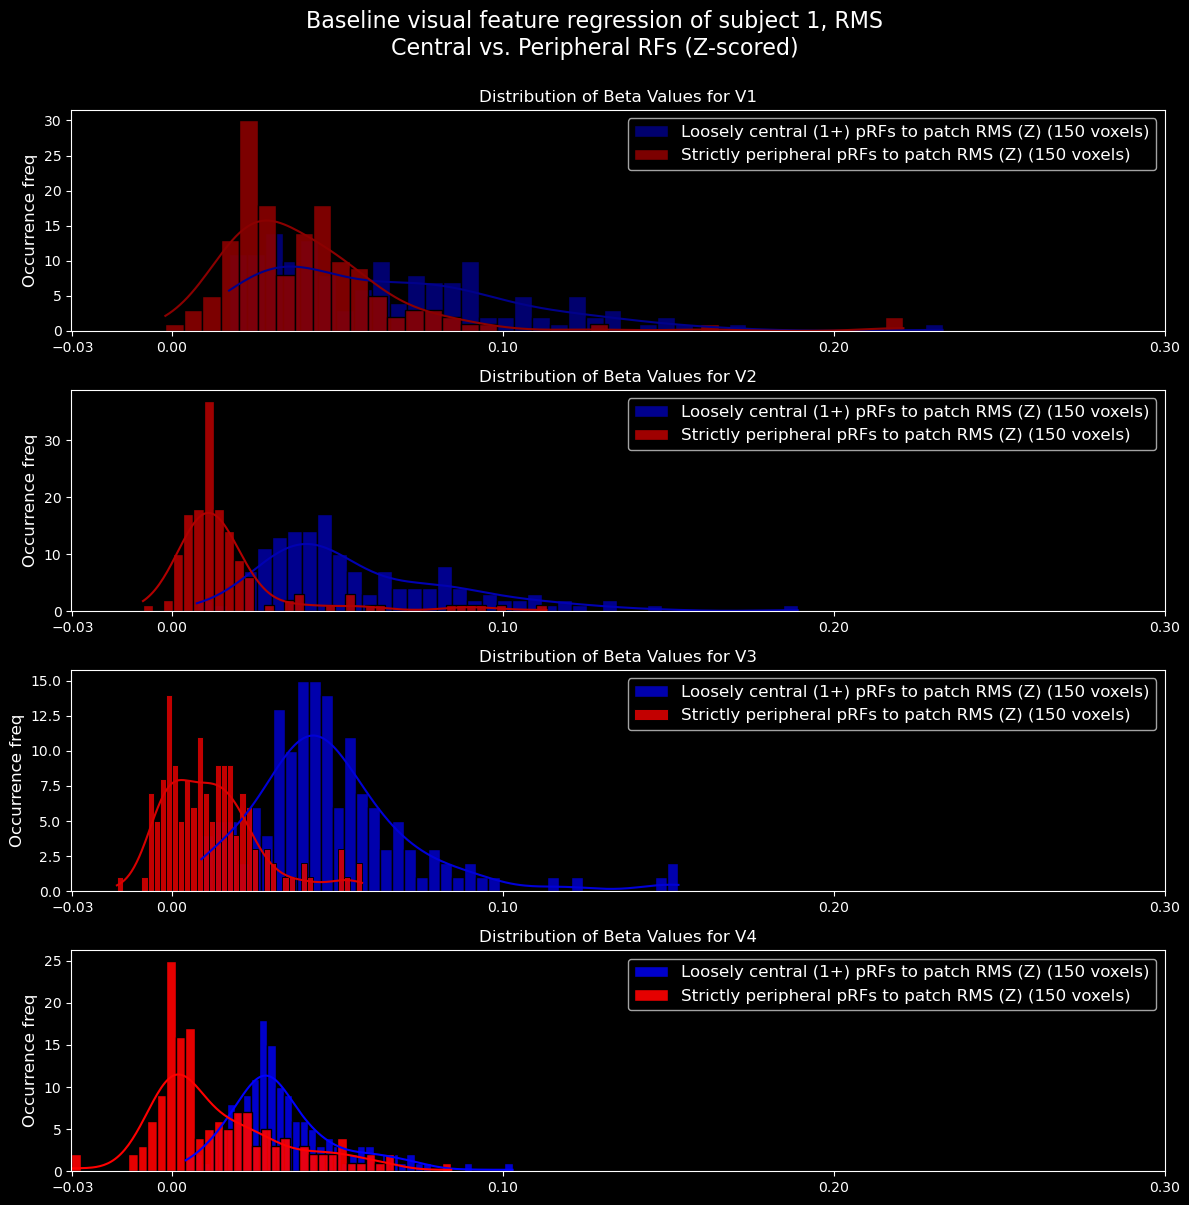

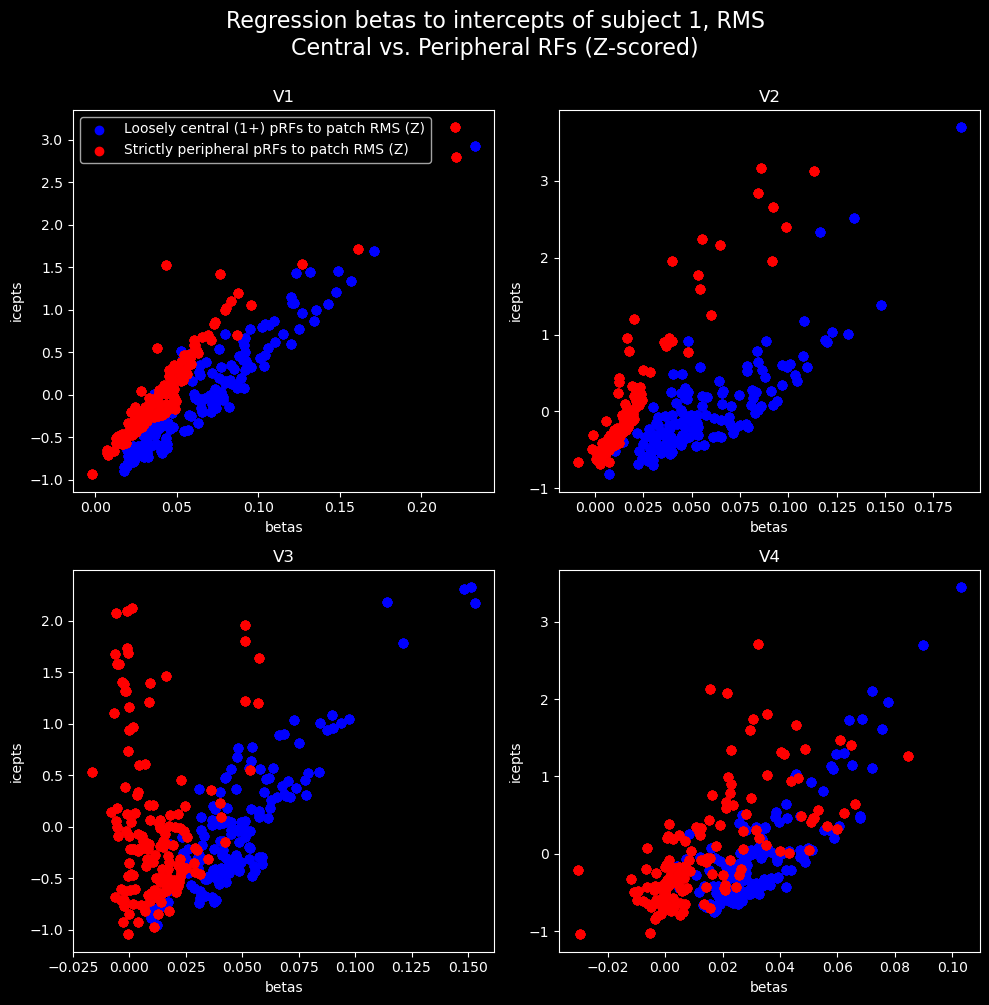

In [114]:
# NEW 
reg_plots(regstash_z['centralprfs']['loose']['rel'], dictdescrip1 = 'Loosely central (1+) pRFs to patch RMS (Z)', comptype = 'Central vs. Peripheral RFs (Z-scored)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS (Z)', beta_hist = True, beta_icept = True)

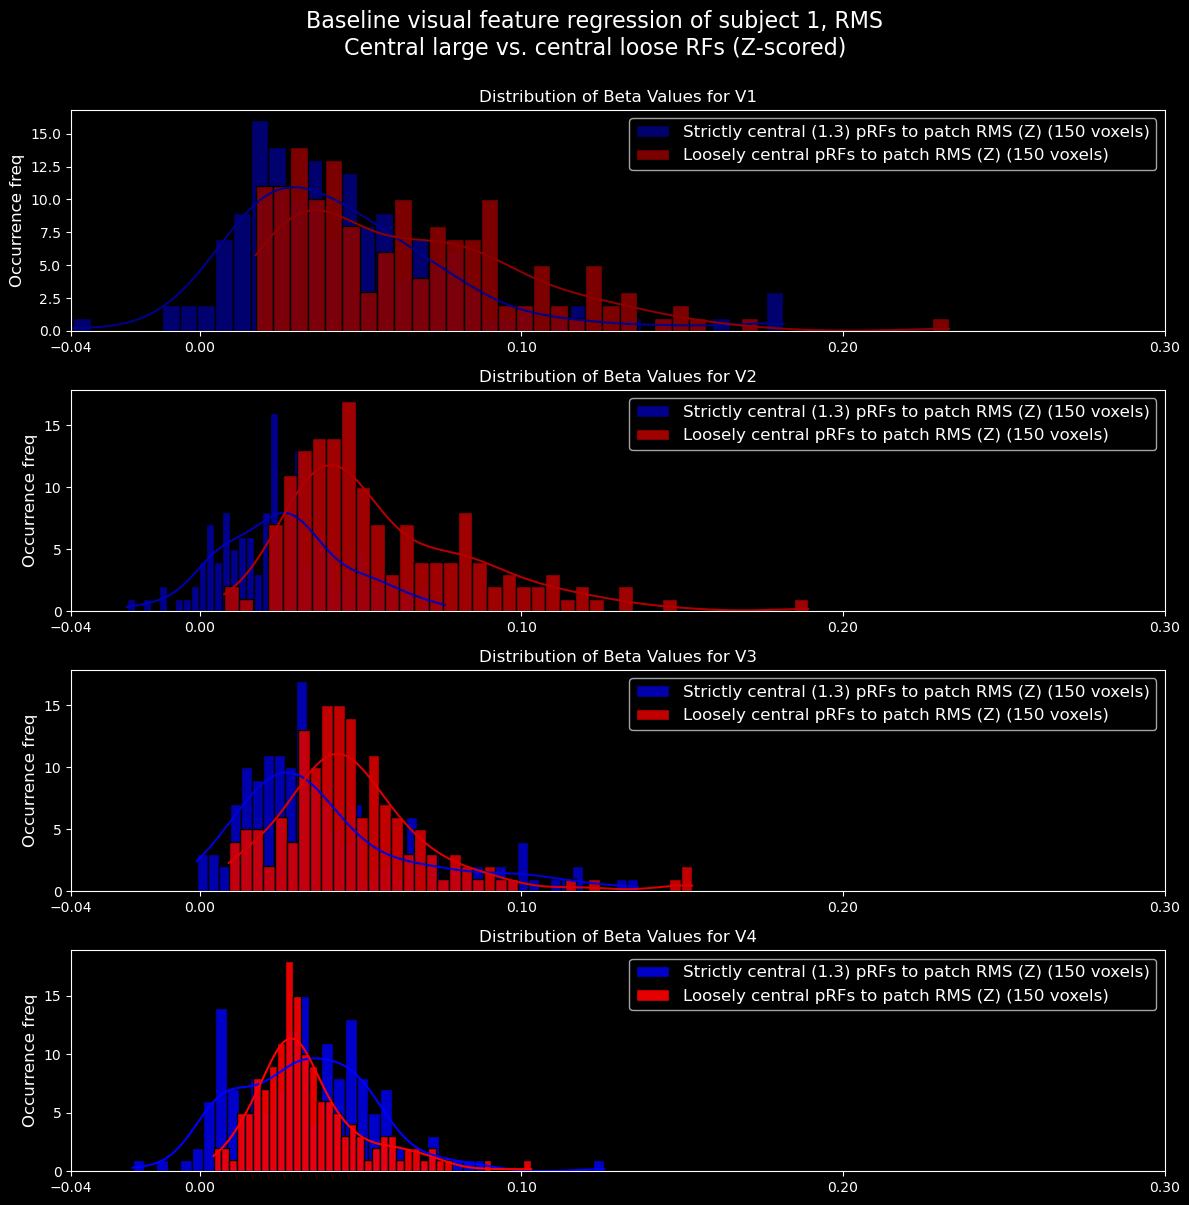

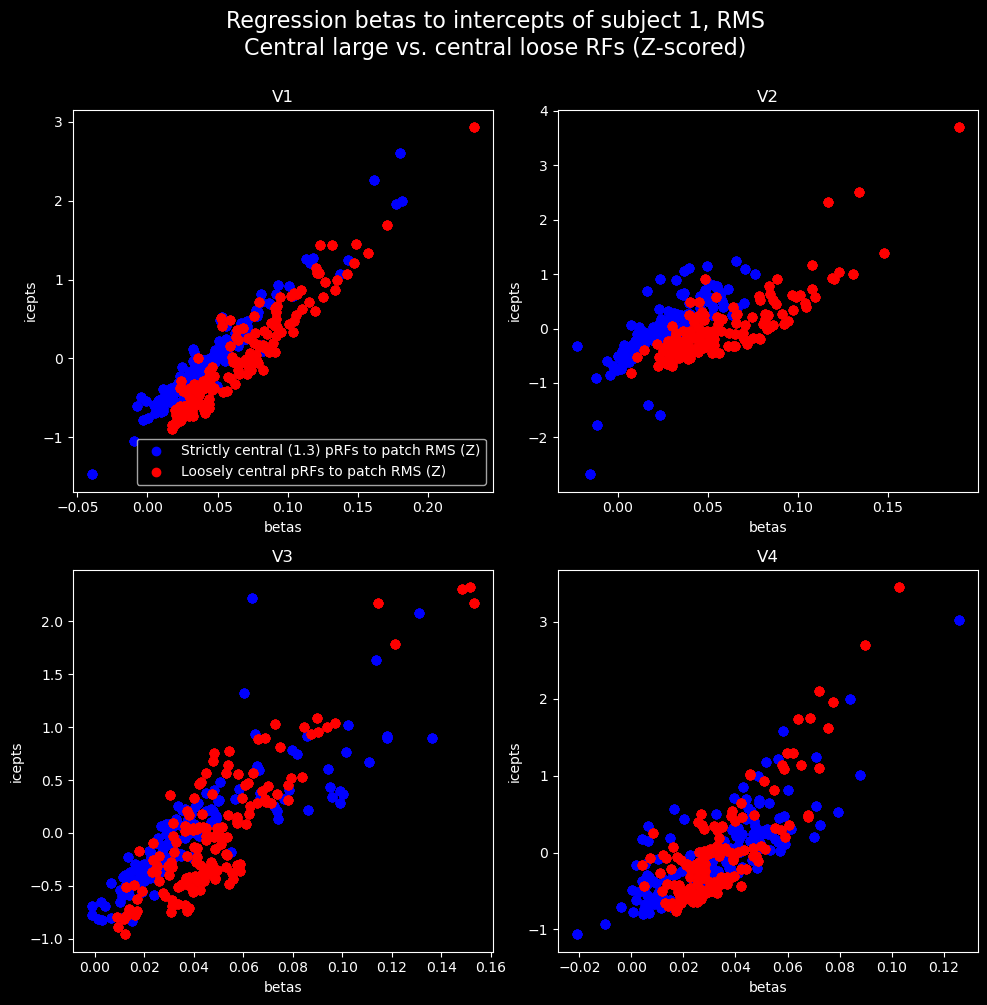

In [115]:
# NEW 
reg_plots(regstash_z['centralprfs']['tight_l']['rel'], dictdescrip1 = 'Strictly central (1.3) pRFs to patch RMS (Z)', comptype = 'Central large vs. central loose RFs (Z-scored)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z['centralprfs']['loose']['rel'], 
                           dictdescrip2 = 'Loosely central pRFs to patch RMS (Z)', beta_hist = True, beta_icept = True)

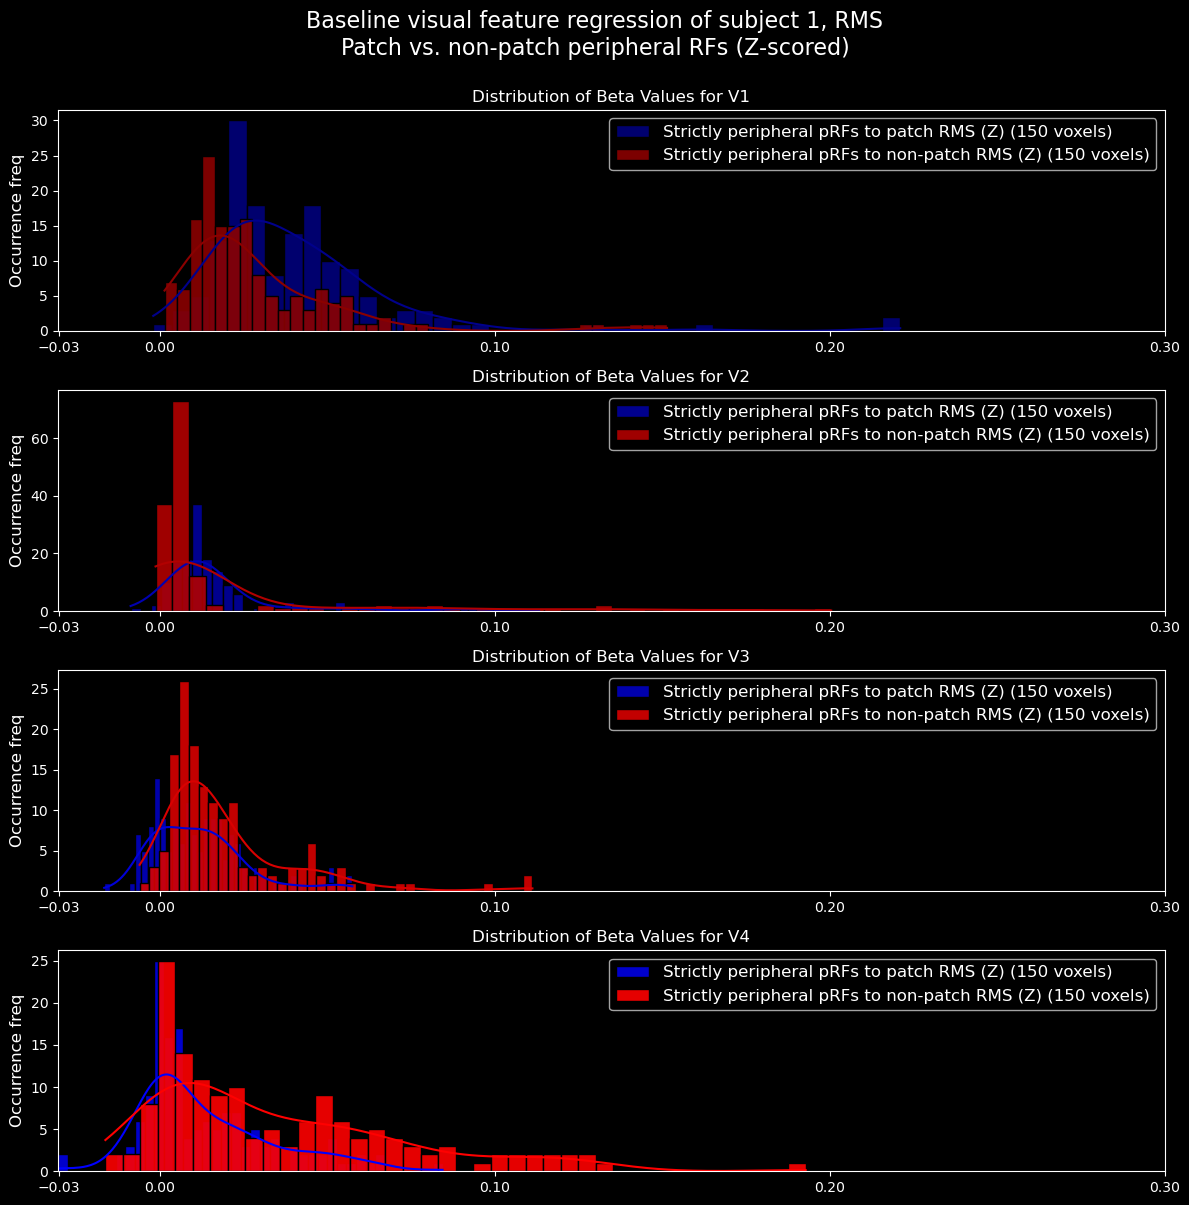

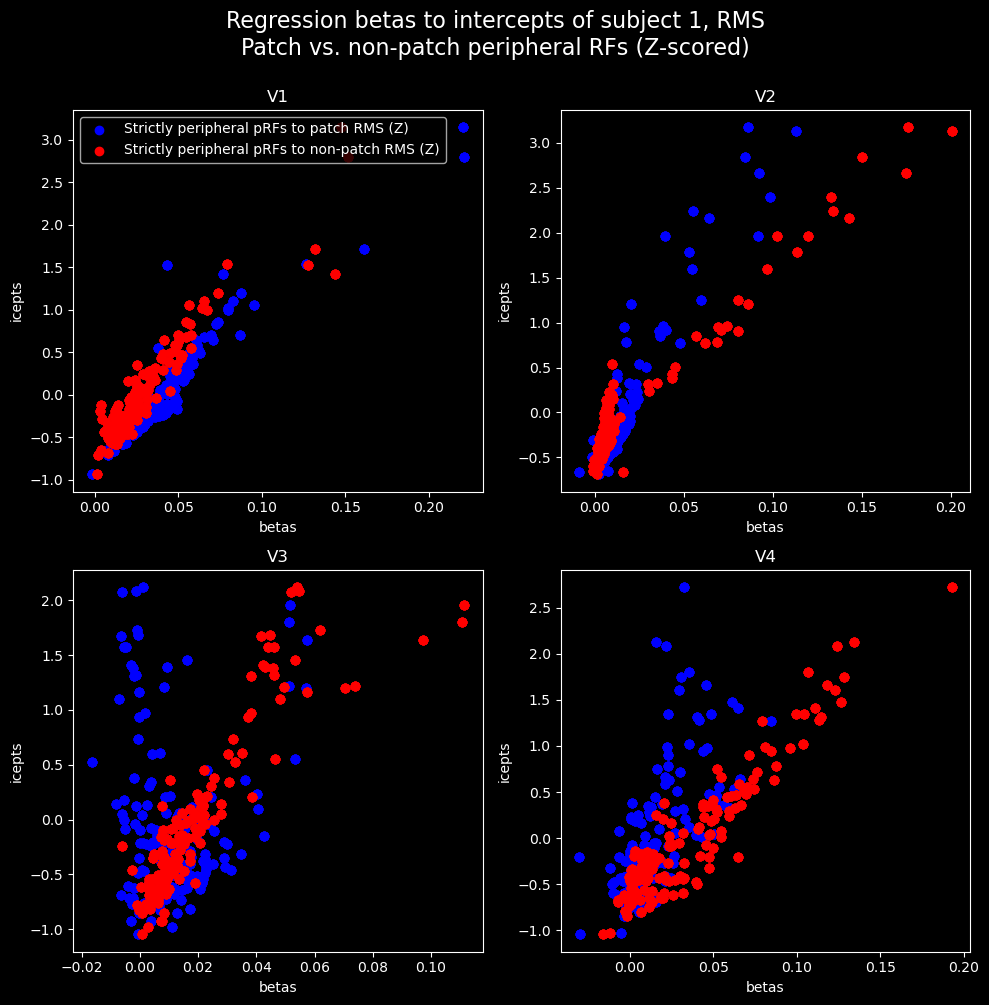

In [116]:
# NEW 
reg_plots(regstash_z['peripheralprfs']['tight']['rel'], dictdescrip1 = 'Strictly peripheral pRFs to patch RMS (Z)', comptype = 'Patch vs. non-patch peripheral RFs (Z-scored)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z['peripheralprfs']['tight']['irrel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to non-patch RMS (Z)', beta_hist = True, beta_icept = True)

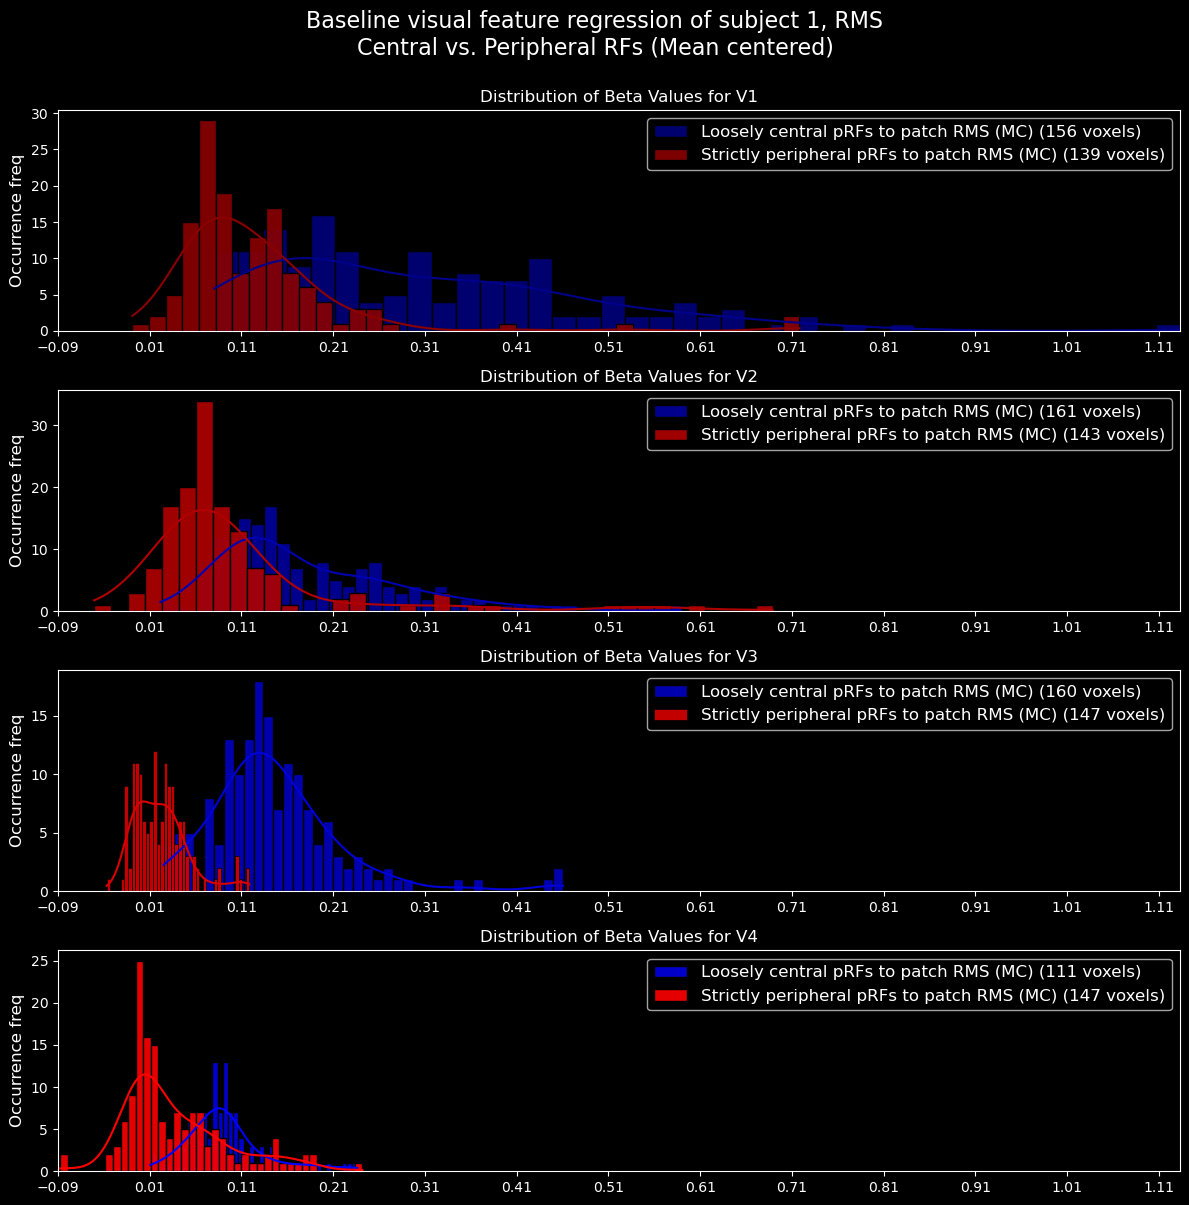

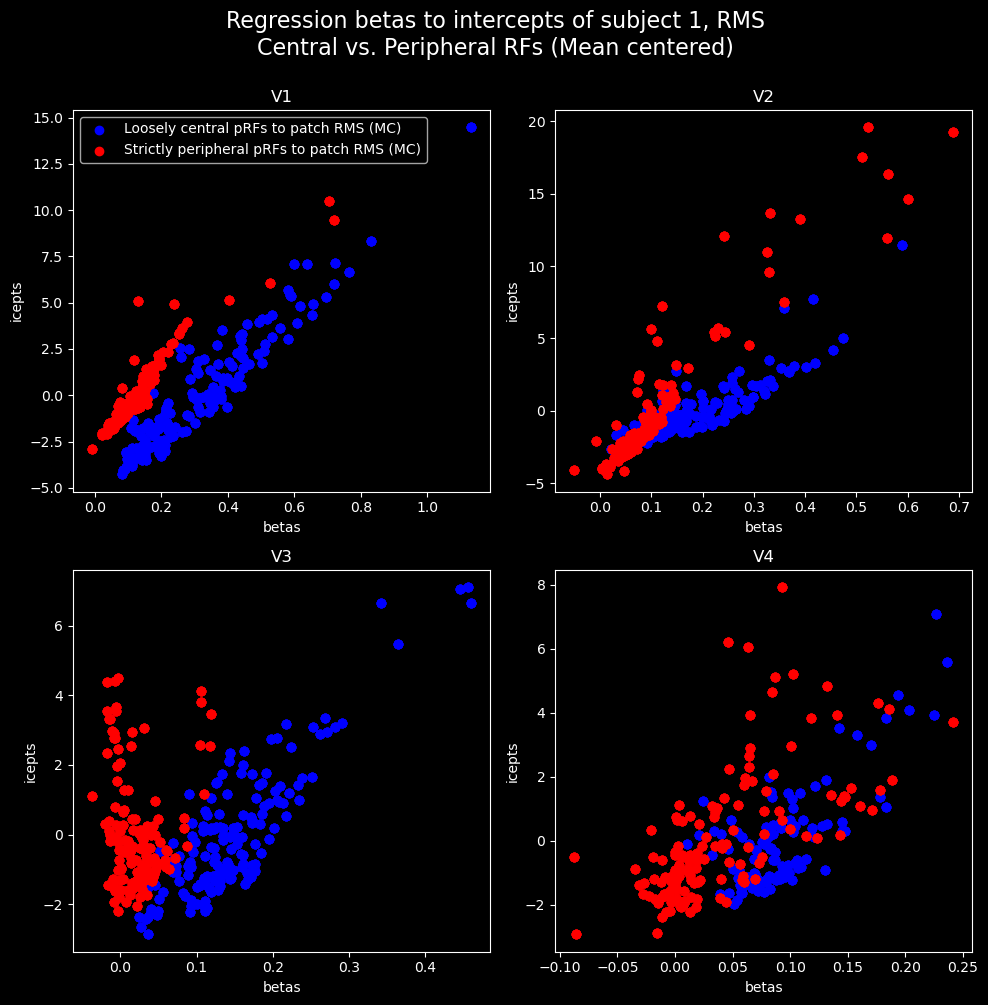

In [55]:

reg_plots(regstash_mc['centralprfs']['loose']['rel'], dictdescrip1 = 'Loosely central pRFs to patch RMS (MC)', comptype = 'Central vs. Peripheral RFs (Mean centered)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_mc['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS (MC)', beta_hist = True, beta_icept = True)

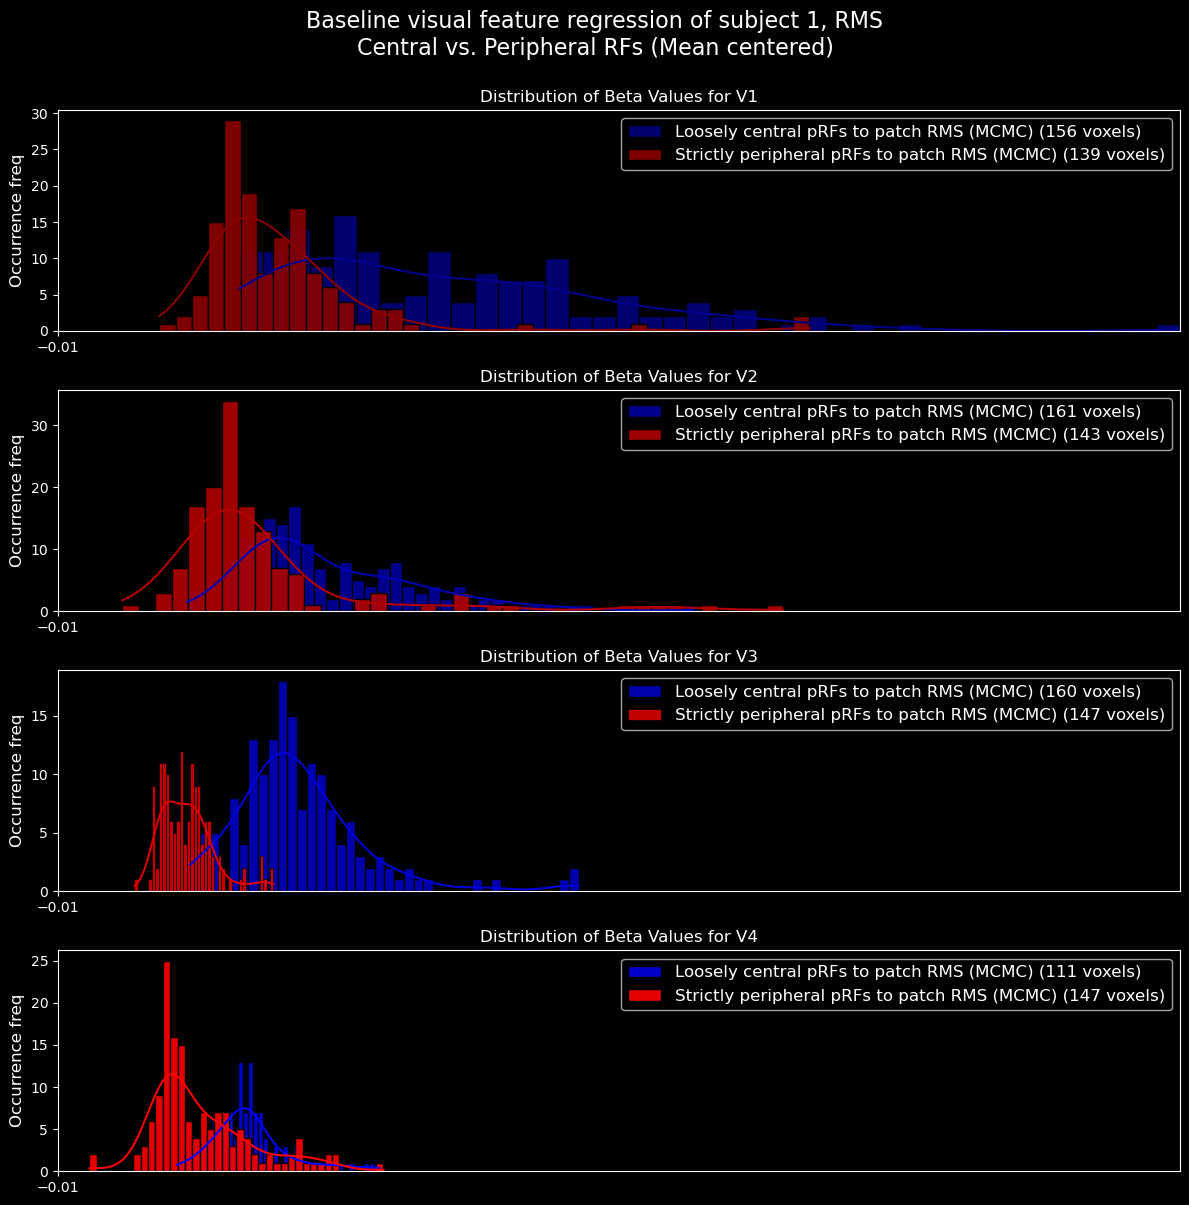

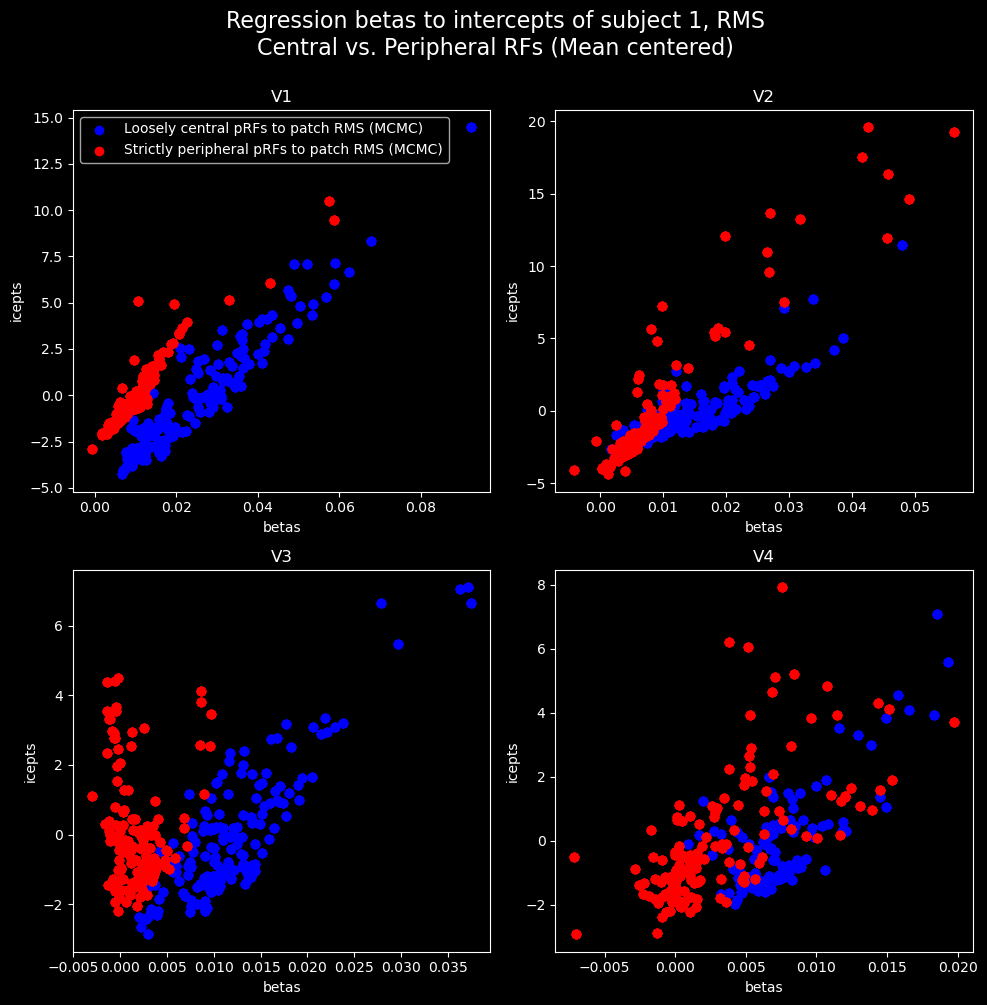

In [56]:

reg_plots(regstash_mcmc['centralprfs']['loose']['rel'], dictdescrip1 = 'Loosely central pRFs to patch RMS (MCMC)', comptype = 'Central vs. Peripheral RFs (Mean centered)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_mcmc['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS (MCMC)', beta_hist = True, beta_icept = True)

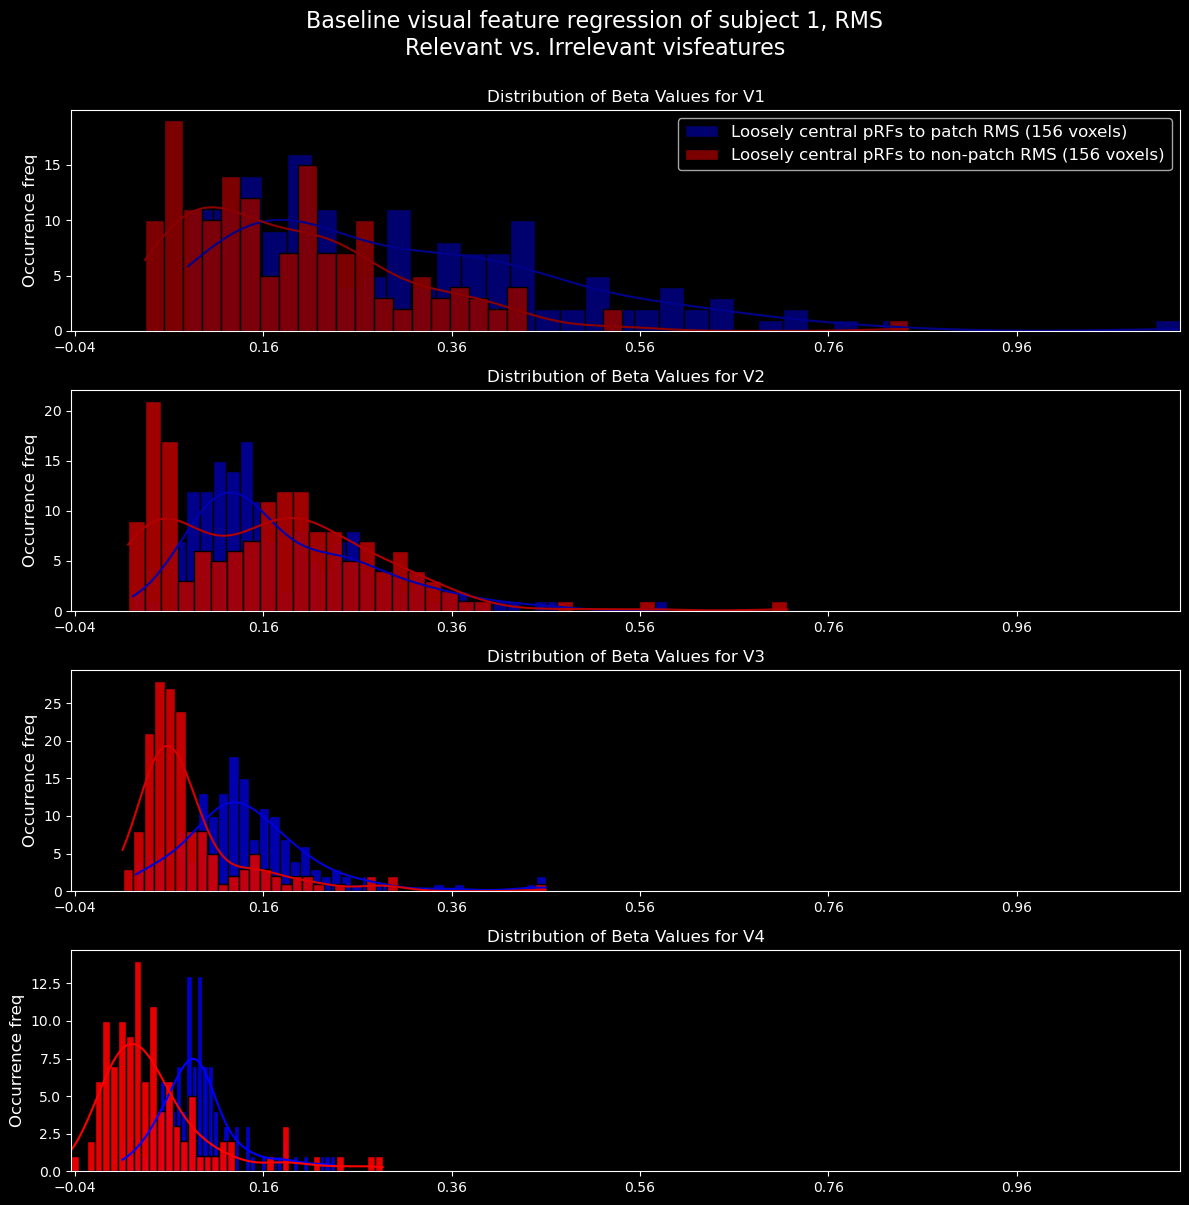

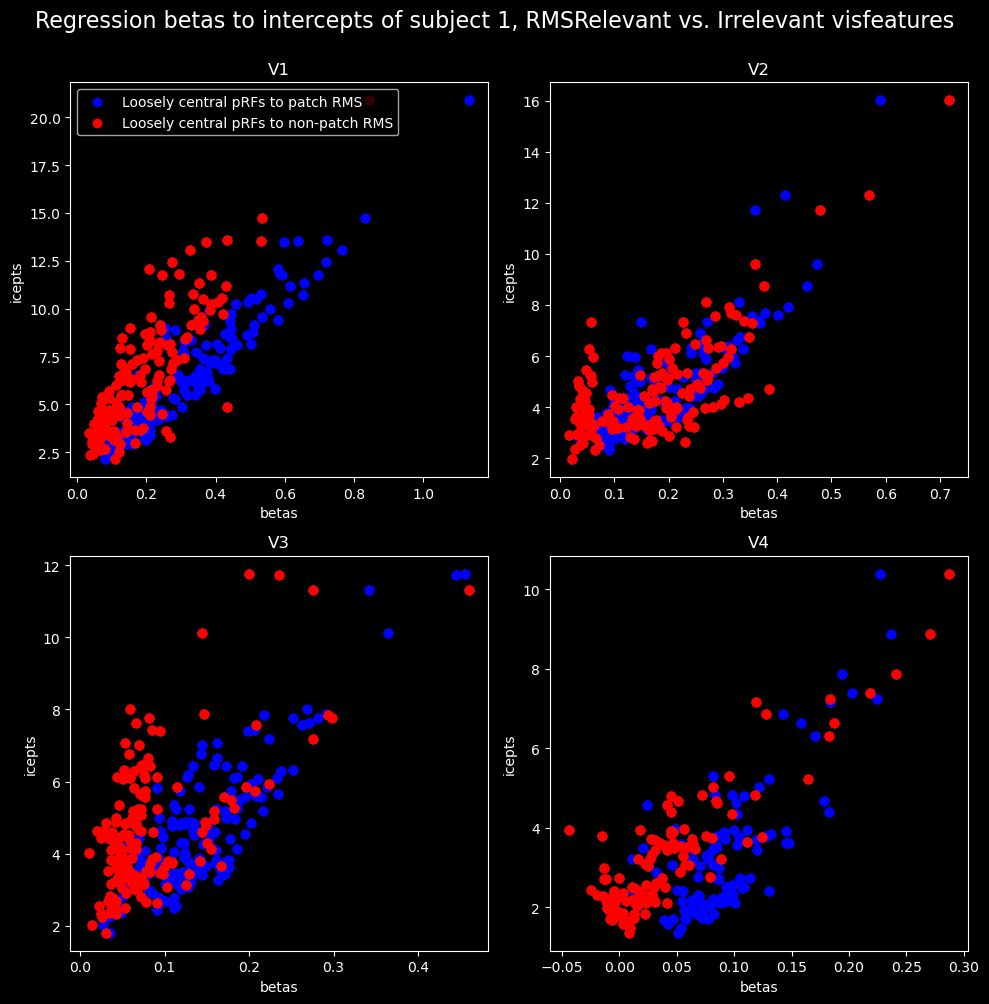

In [23]:

reg_plots(regstash['centralprfs']['loose']['rel'], dictdescrip1 = 'Loosely central pRFs to patch RMS', comptype = 'Relevant vs. Irrelevant visfeatures',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash['centralprfs']['loose']['irrel'], 
                           dictdescrip2 = 'Loosely central pRFs to non-patch RMS', beta_hist = True, beta_icept = True)

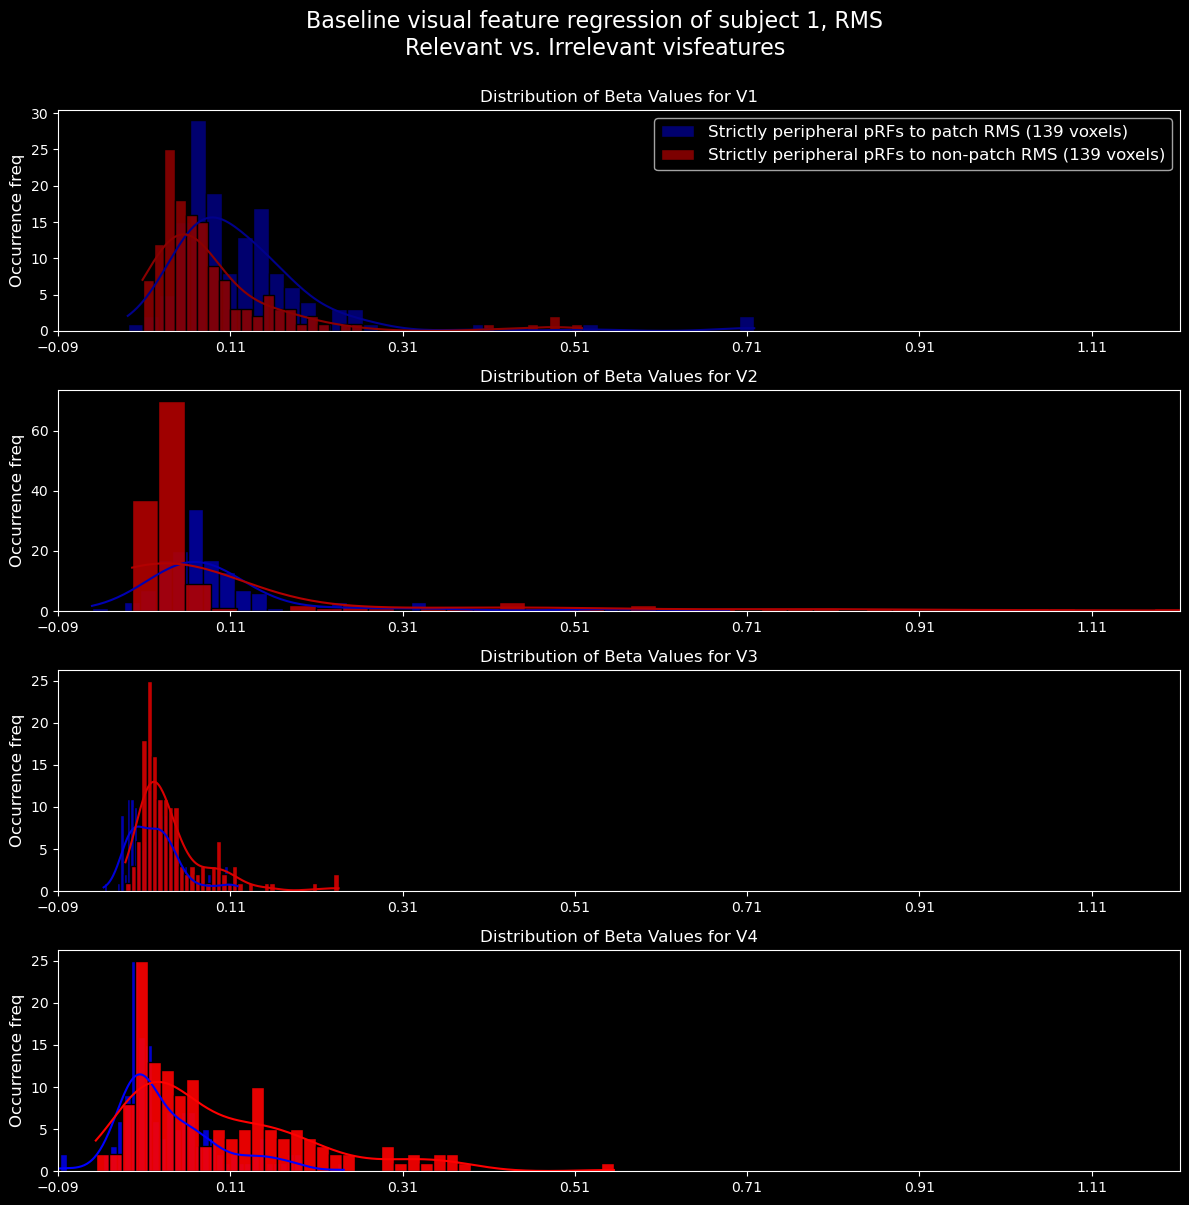

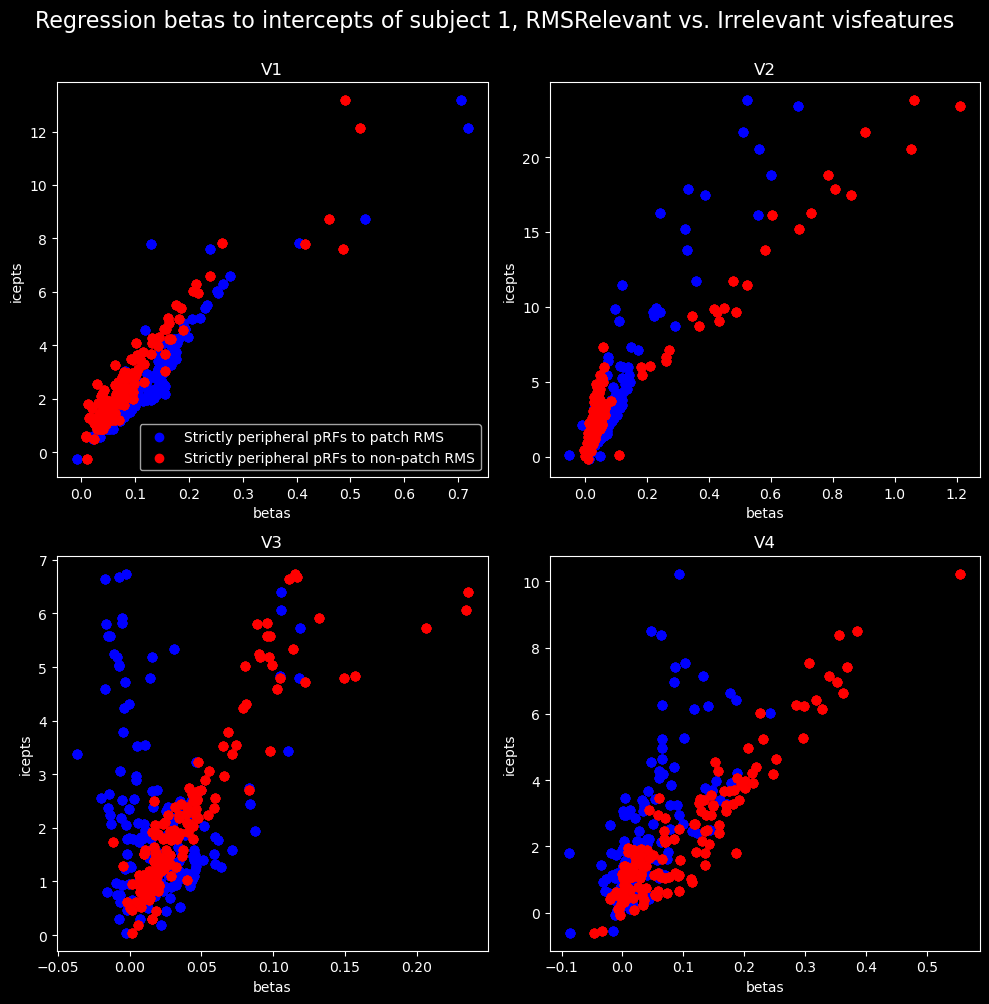

In [22]:

reg_plots(regstash['peripheralprfs']['tight']['rel'], dictdescrip1 = 'Strictly peripheral pRFs to patch RMS', comptype = 'Relevant vs. Irrelevant visfeatures',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash['peripheralprfs']['tight']['irrel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to non-patch RMS', beta_hist = True, beta_icept = True)

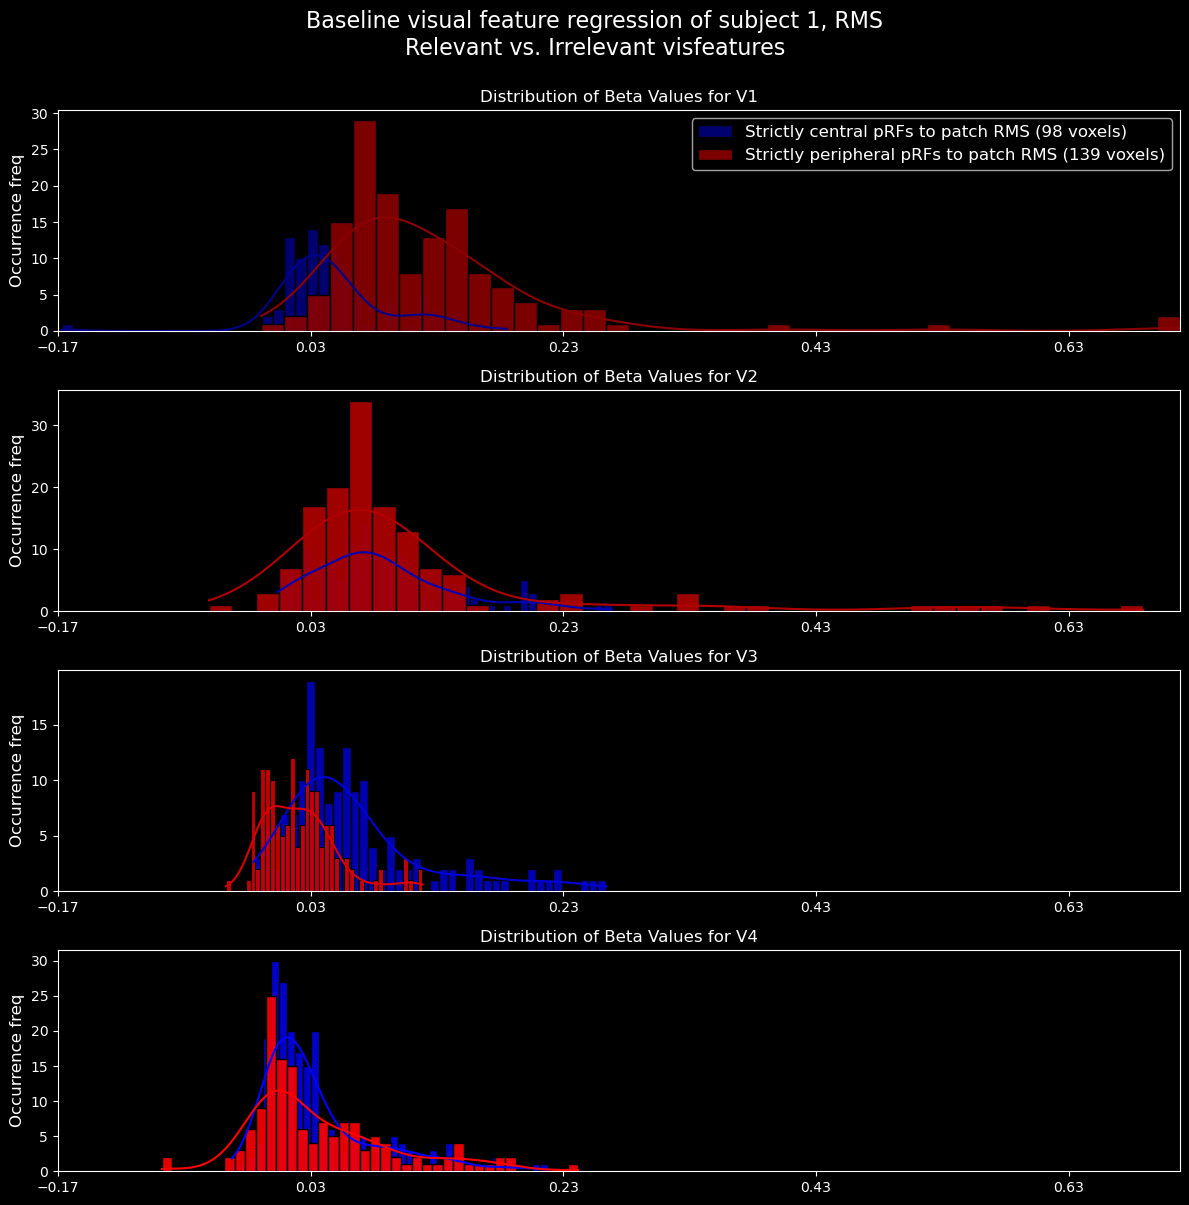

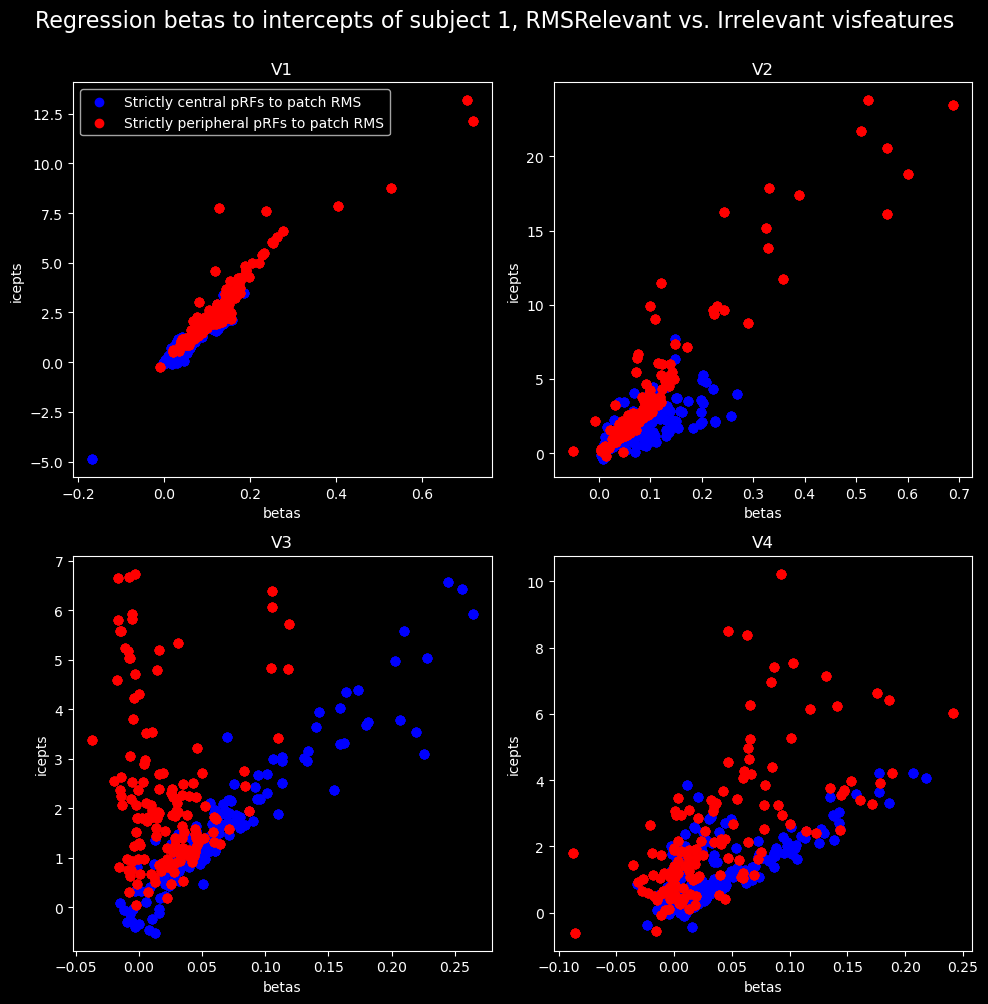

In [27]:

reg_plots(regstash['centralprfs']['tight']['rel'], dictdescrip1 = 'Strictly central pRFs to patch RMS', comptype = 'Relevant vs. Irrelevant visfeatures',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS', beta_hist = True, beta_icept = True)

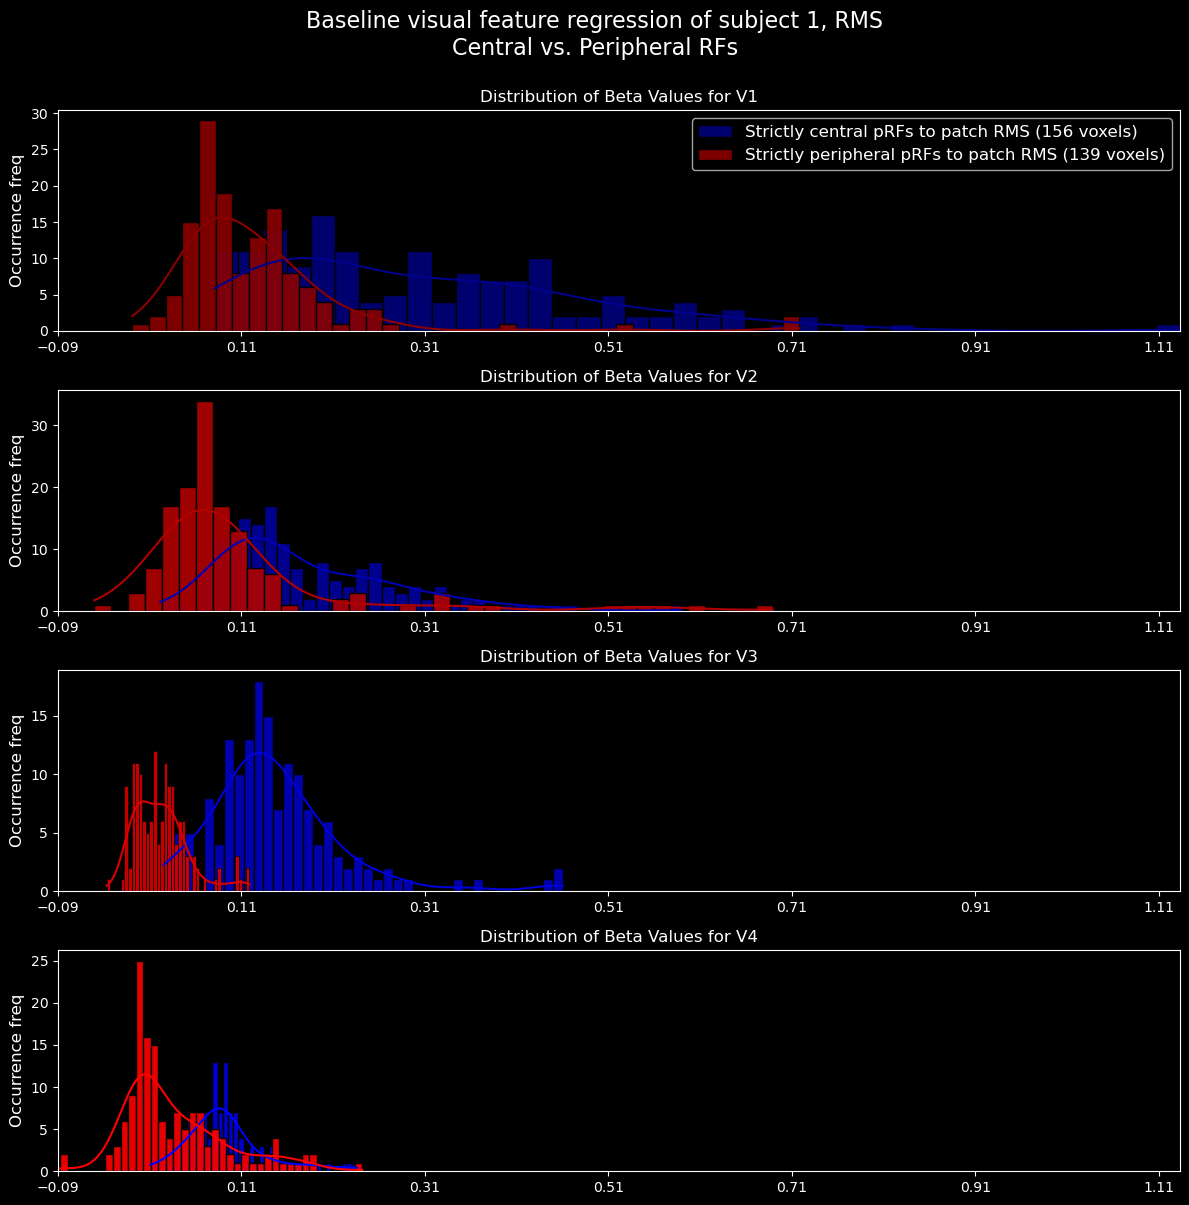

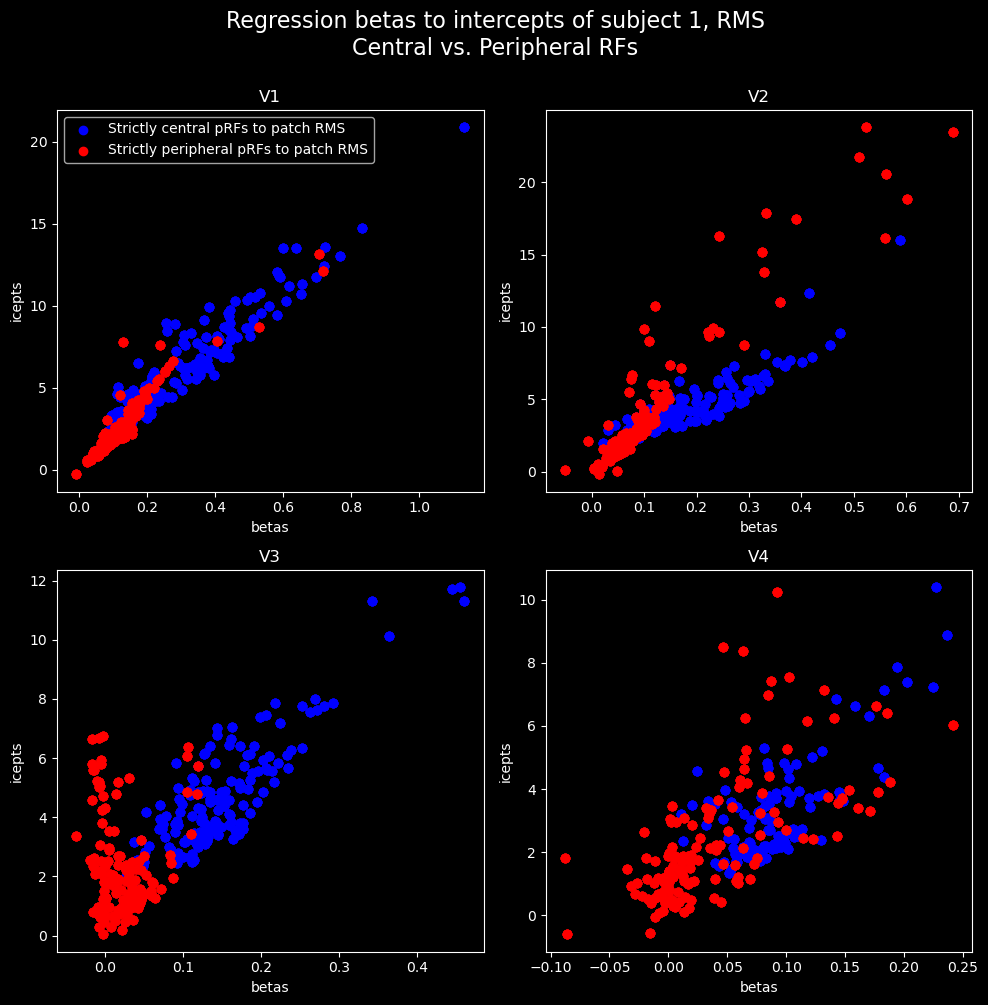

In [26]:

reg_plots(regstash['centralprfs']['loose']['rel'], dictdescrip1 = 'Strictly central pRFs to patch RMS', comptype = 'Central vs. Peripheral RFs',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS', beta_hist = True, beta_icept = True)

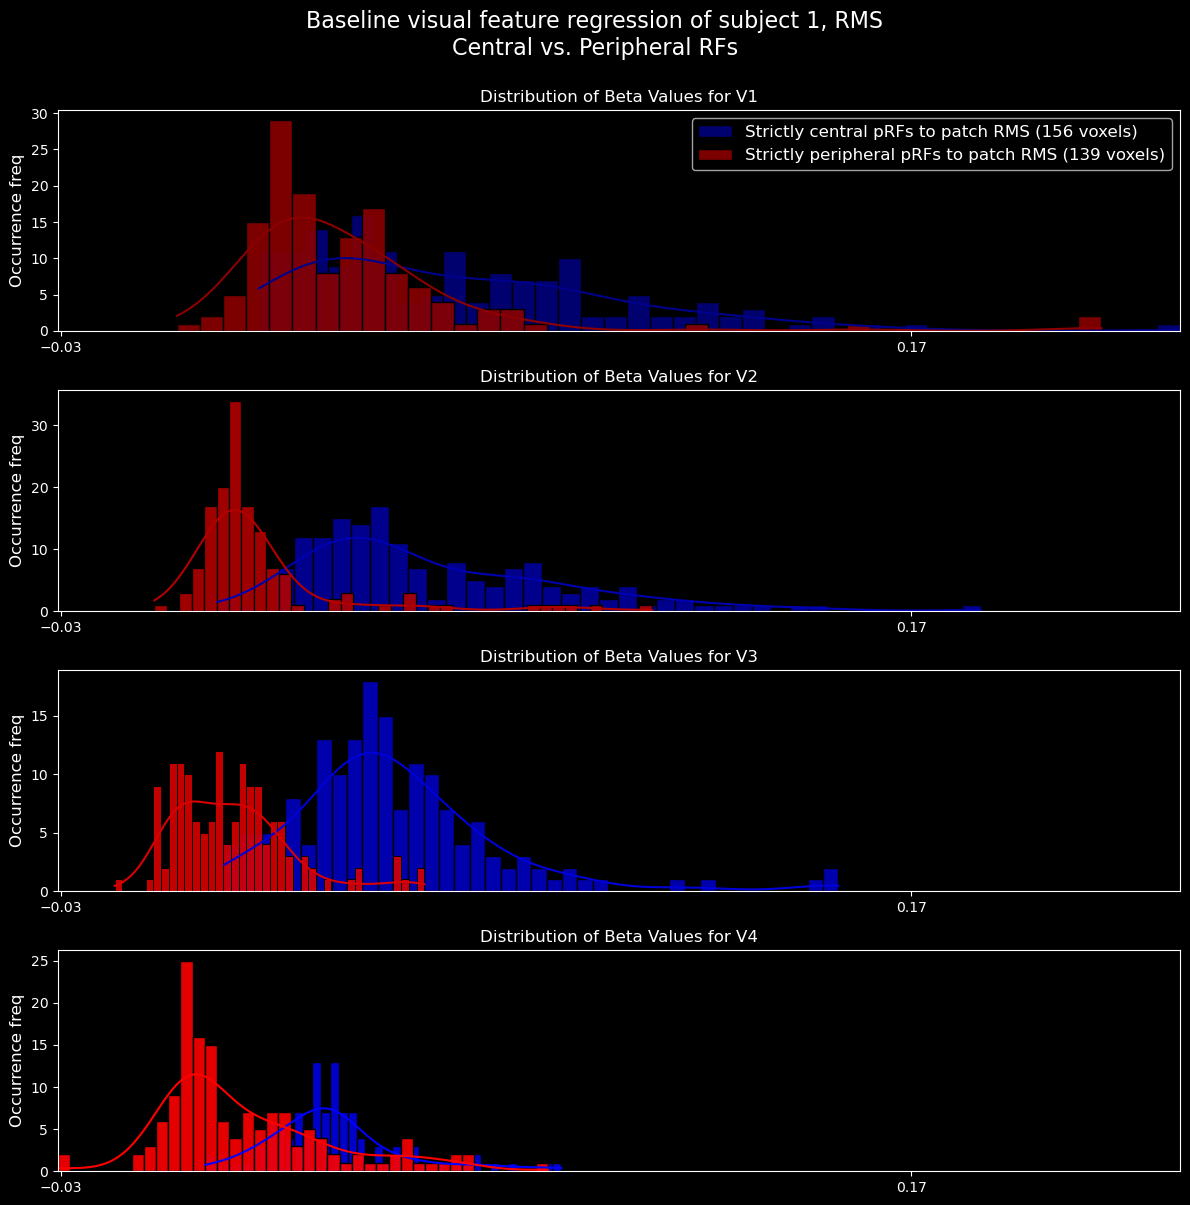

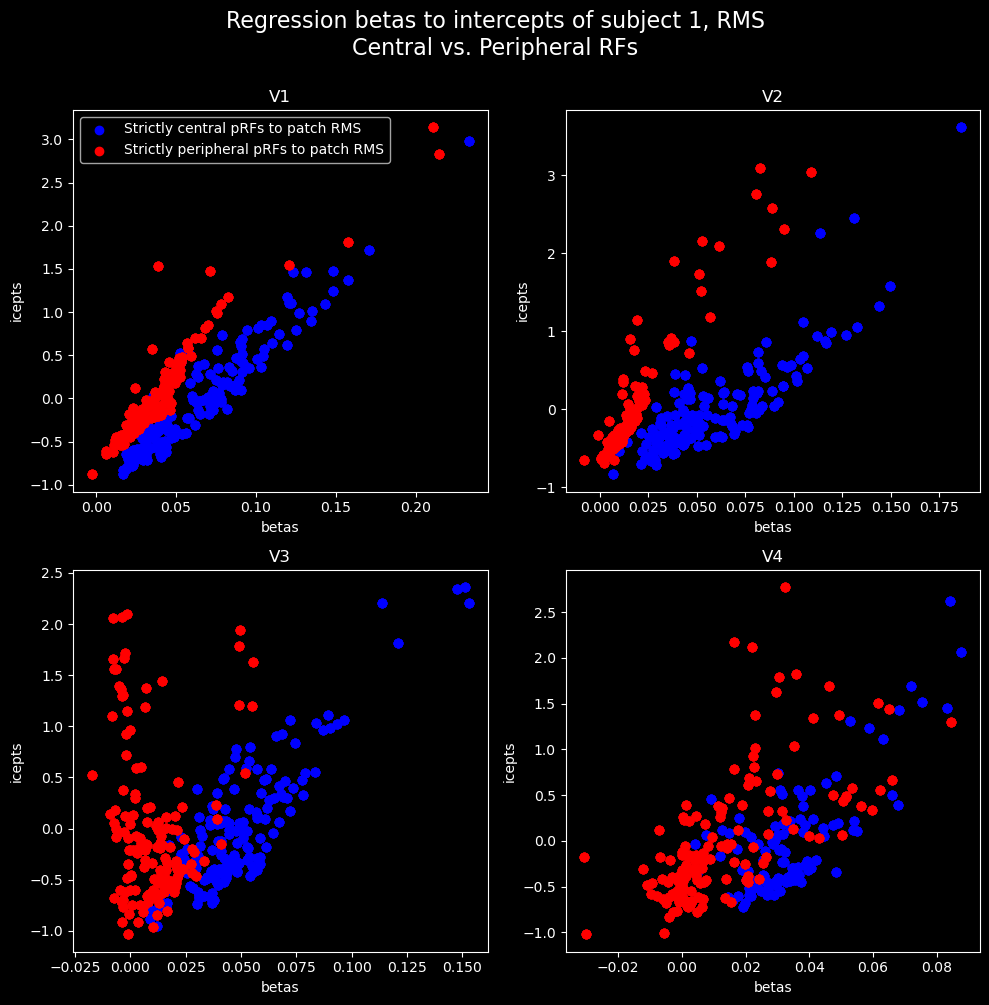

In [27]:

reg_plots(regstash_z['centralprfs']['loose']['rel'], dictdescrip1 = 'Strictly central pRFs to patch RMS', comptype = 'Central vs. Peripheral RFs',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS', beta_hist = True, beta_icept = True)

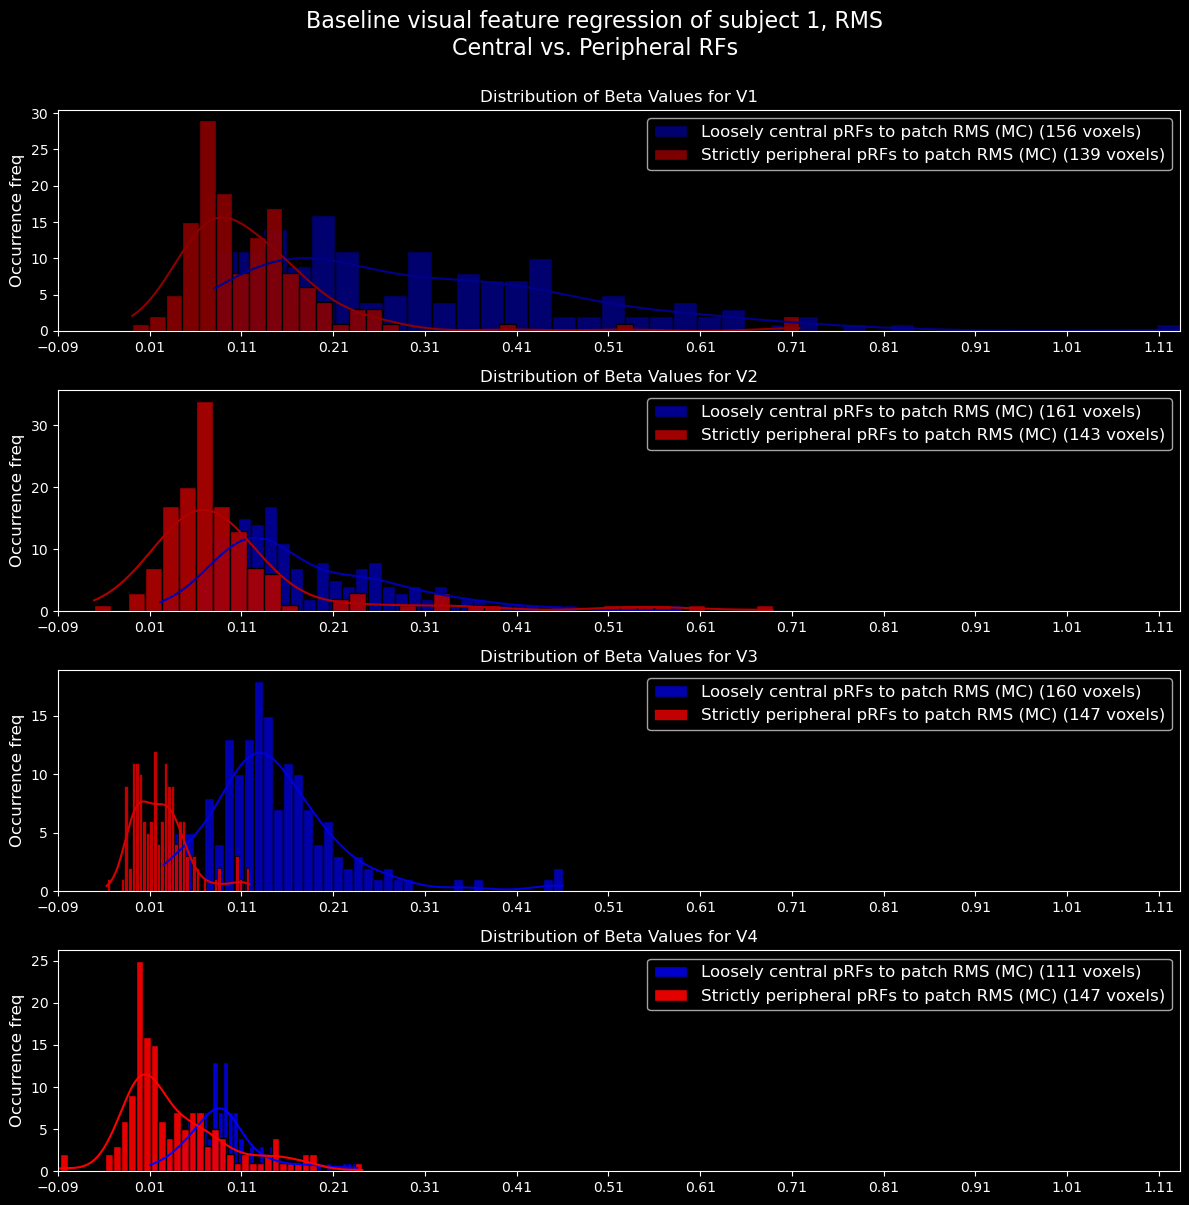

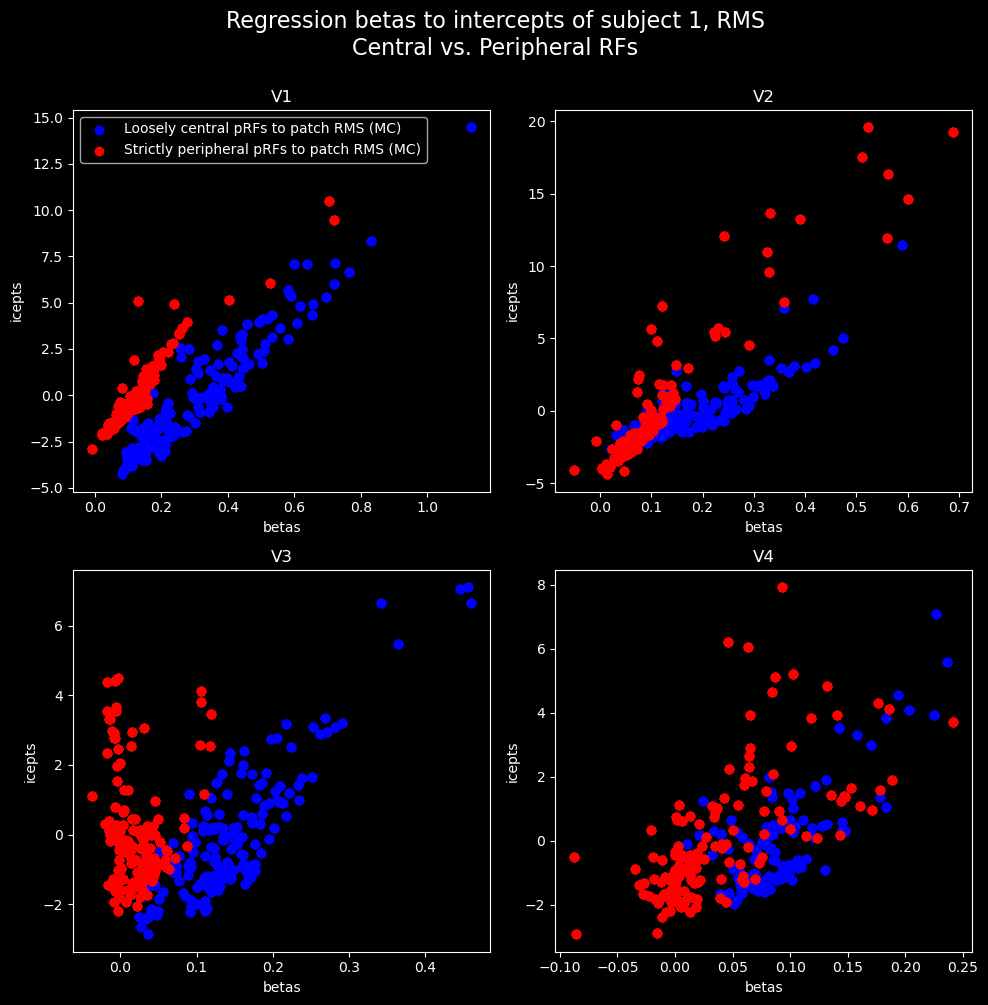

In [17]:

reg_plots(regstash_mc['centralprfs']['loose']['rel'], dictdescrip1 = 'Loosely central pRFs to patch RMS (MC)', comptype = 'Central vs. Peripheral RFs',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_mc['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS (MC)', beta_hist = True, beta_icept = True)

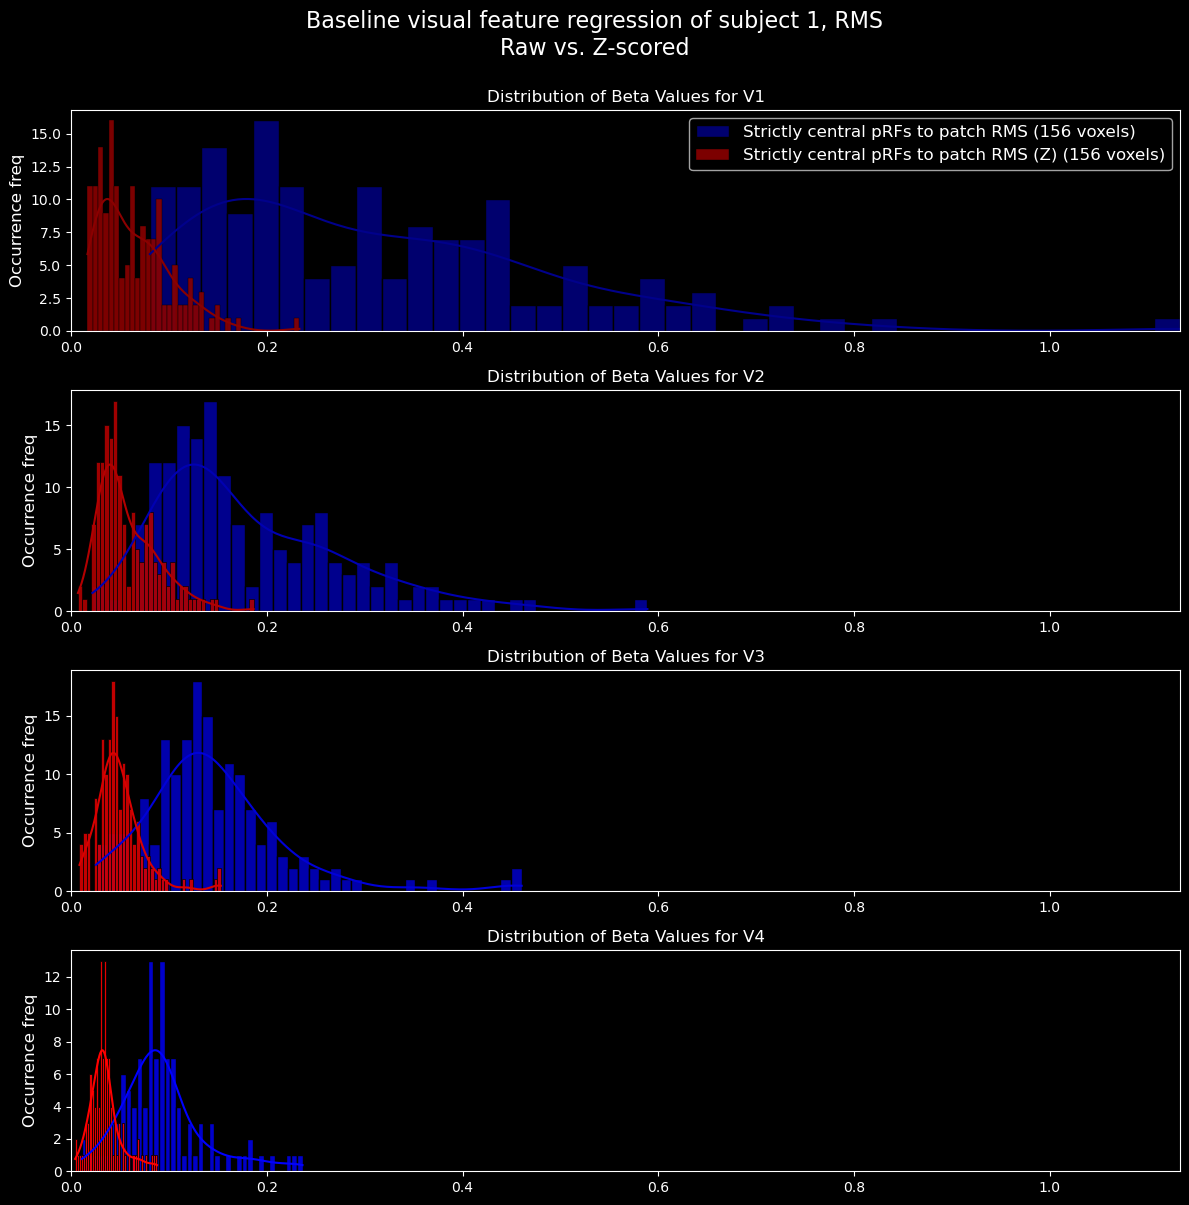

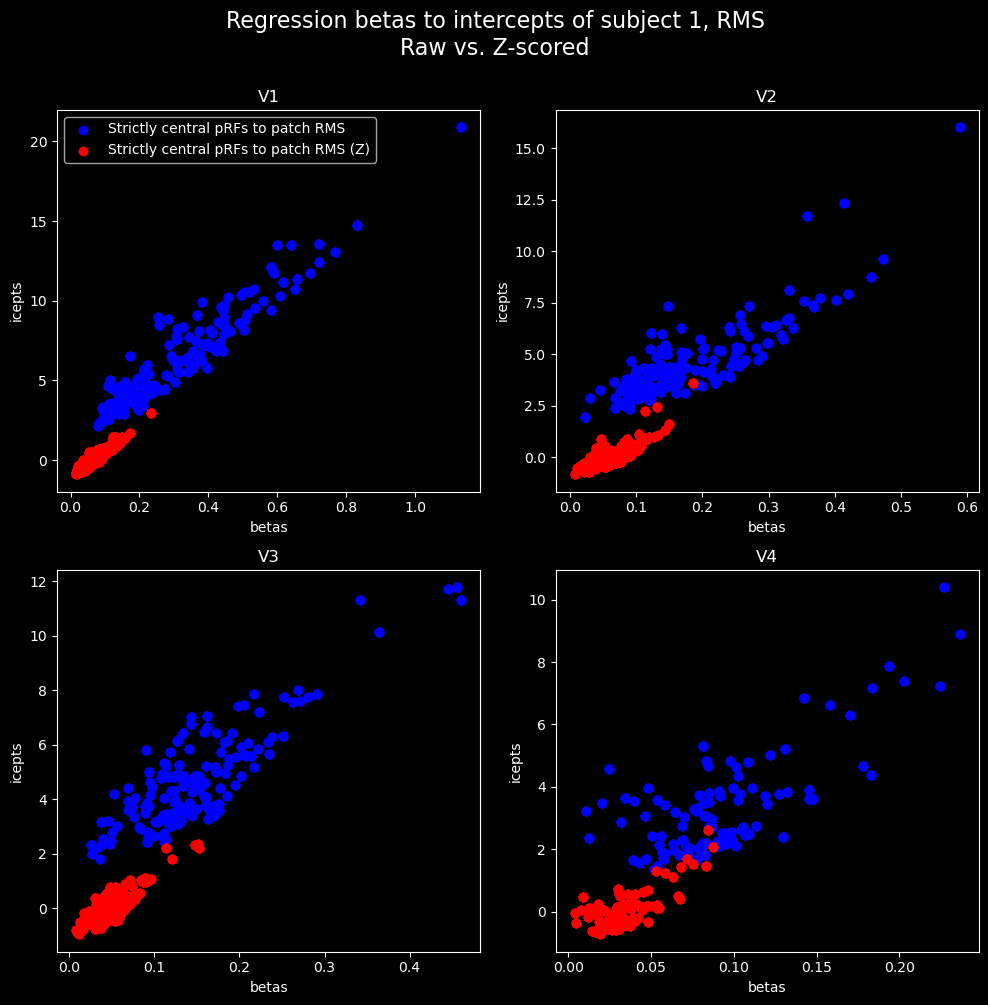

In [18]:

reg_plots(regstash['centralprfs']['loose']['rel'], dictdescrip1 = 'Strictly central pRFs to patch RMS', comptype = 'Raw vs. Z-scored',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z['centralprfs']['loose']['rel'], 
                           dictdescrip2 = 'Strictly central pRFs to patch RMS (Z)', beta_hist = True, beta_icept = True)

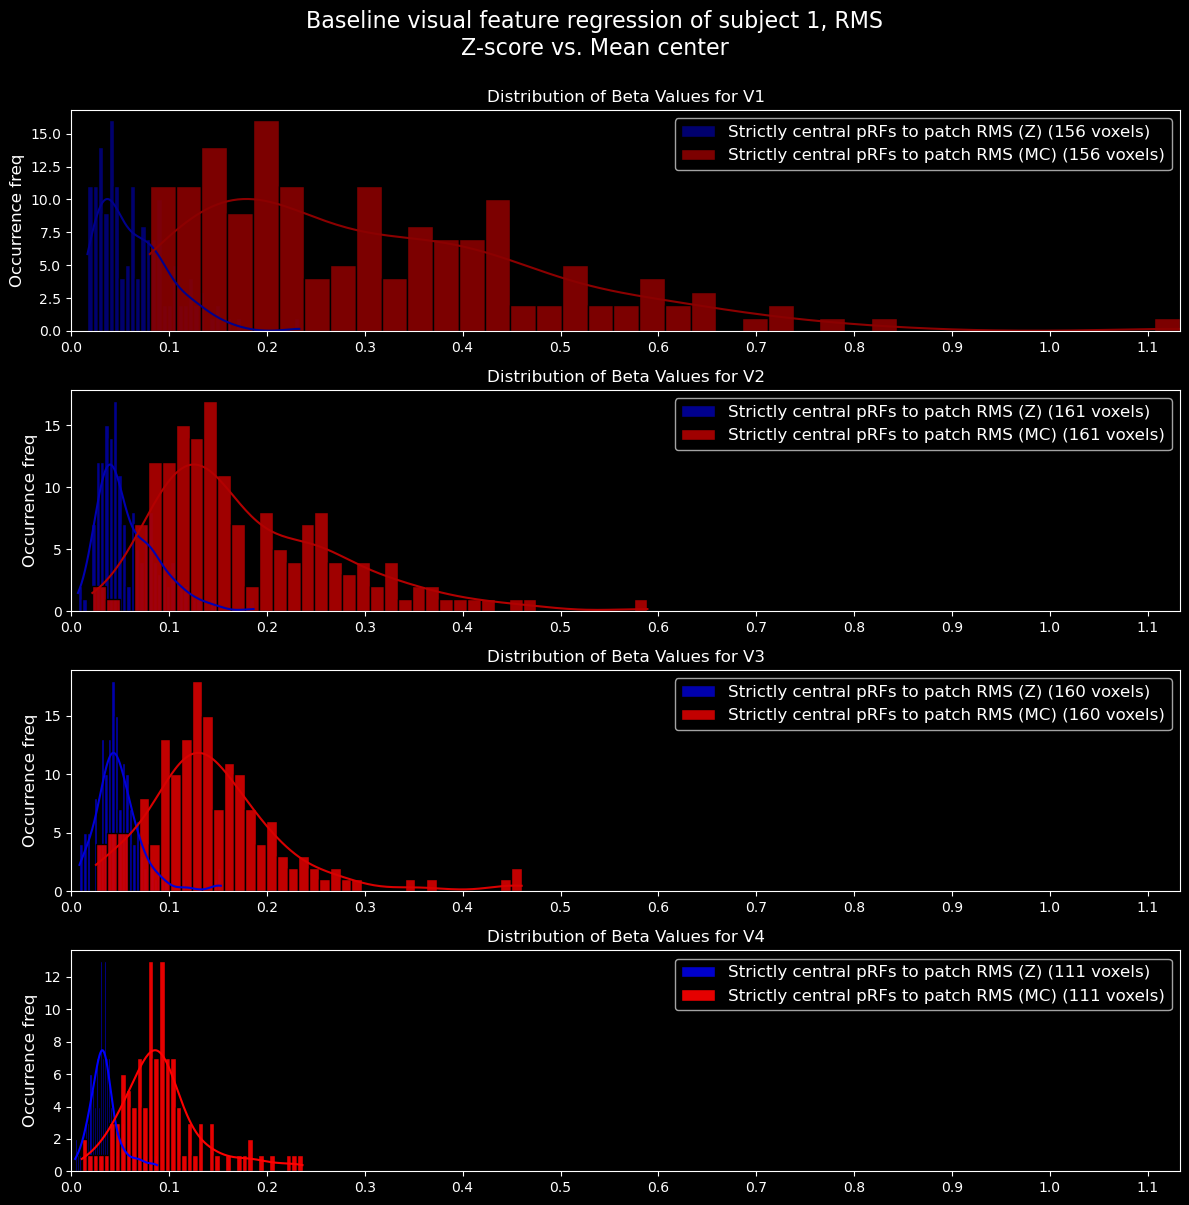

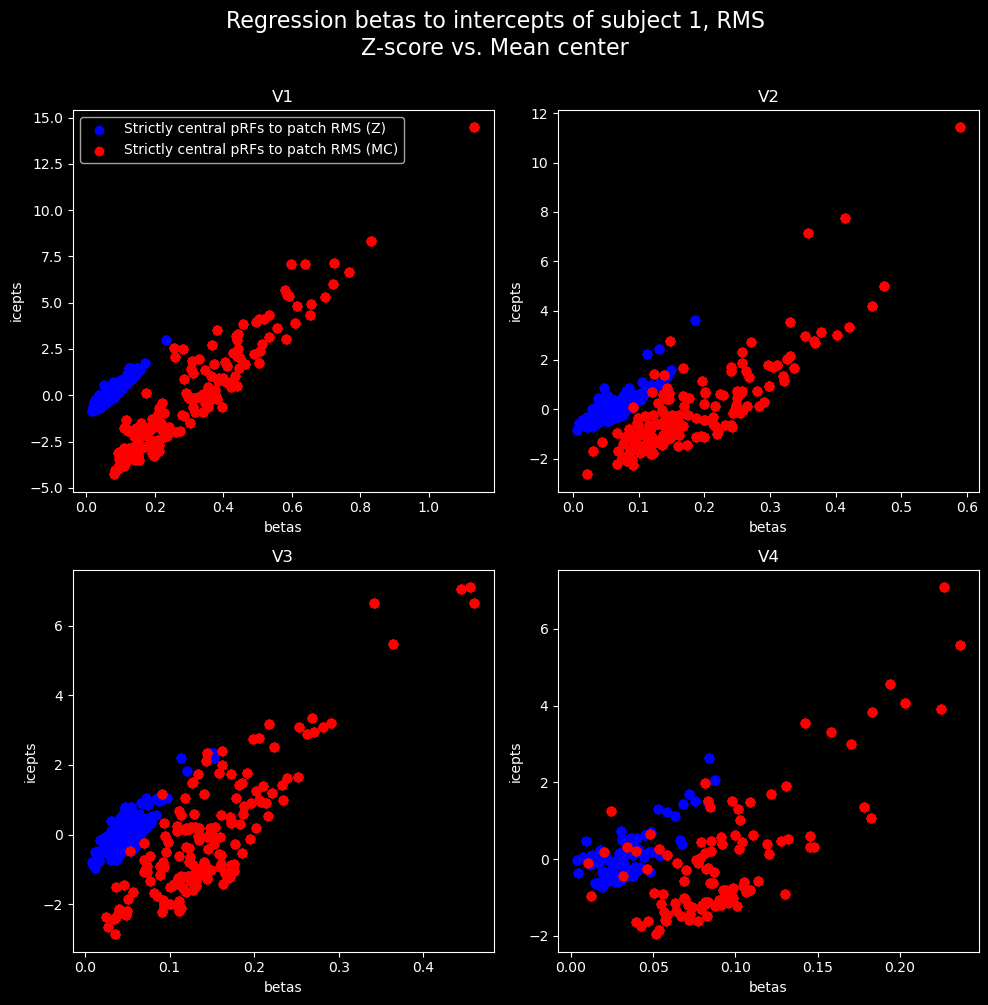

In [18]:

reg_plots(regstash_z['centralprfs']['loose']['rel'], dictdescrip1 = 'Strictly central pRFs to patch RMS (Z)', comptype = 'Z-score vs. Mean center',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_mc['centralprfs']['loose']['rel'], 
                           dictdescrip2 = 'Strictly central pRFs to patch RMS (MC)', beta_hist = True, beta_icept = True)